In [ ]:
# Cell 1: Install Reqs and Import Dependencies
!pip install transformers datasets evaluate seqeval scikit-learn matplotlib huggingface_hub

import os
import numpy as np
import pandas as pd
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer,
    DataCollatorForTokenClassification
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import login, create_repo, upload_folder

login(token="-")

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b3ec265b70af0cc8a6a5d1634f9a7edf4fd0c11637490bc898be85f202edd7d8
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:

In [ ]:

# Class 1: Load Dataset
class DatasetLoader:
    def __init__(self, dataset_name="rjac/kaggle-entity-annotated-corpus-ner-dataset"):
        self.label_names = [
            "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-GEO", "I-GEO",
            "B-GPE", "I-GPE", "B-TIM", "I-TIM", "B-ART", "I-ART",
            "B-EVE", "I-EVE", "B-NAT", "I-NAT"
        ]
        self.id2label = {i: label for i, label in enumerate(self.label_names)}
        self.label2id = {label: i for i, label in self.id2label.items()}

        raw_datasets = load_dataset(dataset_name)
        train_test_split = raw_datasets["train"].train_test_split(test_size=0.2, seed=42)
        train_val_split = train_test_split["train"].train_test_split(test_size=0.1, seed=42)

        self.datasets = DatasetDict({
            "train": train_val_split["train"],
            "validation": train_val_split["test"],
            "test": train_test_split["test"],
        })

    def align_labels_with_tokens(self, labels, word_ids):
        return [-100 if word_id is None else labels[word_id] for word_id in word_ids]

    def tokenize_and_align_labels(self, examples, tokenizer):
        tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
        tokenized_inputs["labels"] = [
            self.align_labels_with_tokens(labels, tokenized_inputs.word_ids(i))
            for i, labels in enumerate(examples["ner_tags"])
        ]
        return tokenized_inputs

    def get_datasets(self, tokenizer):
        return self.datasets.map(
            lambda examples: self.tokenize_and_align_labels(examples, tokenizer),
            batched=True, remove_columns=self.datasets["train"].column_names
        )

In [ ]:
# Pastikan sudah ada instance dari DatasetLoader
dataset_loader = DatasetLoader()

# Akses dataset yang sudah diproses
datasets = dataset_loader.datasets

# Cek jumlah baris untuk tiap subset
print(f"Train set: {len(datasets['train'])} rows")
print(f"Validation set: {len(datasets['validation'])} rows")
print(f"Test set: {len(datasets['test'])} rows")

# Tampilkan satu contoh dari tiap subset
print("\nSample from Train set:", datasets["train"][0])
print("\nSample from Validation set:", datasets["validation"][0])
print("\nSample from Test set:", datasets["test"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

(…)-00000-of-00004-e7c482bd9e74046f.parquet:   0%|          | 0.00/857k [00:00<?, ?B/s]

(…)-00001-of-00004-8e5af59a8884c020.parquet:   0%|          | 0.00/860k [00:00<?, ?B/s]

(…)-00002-of-00004-8838aa9871a9e9b2.parquet:   0%|          | 0.00/857k [00:00<?, ?B/s]

(…)-00003-of-00004-d4161cf902a01090.parquet:   0%|          | 0.00/823k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/47959 [00:00<?, ? examples/s]

Train set: 34530 rows
Validation set: 3837 rows
Test set: 9592 rows

Sample from Train set: {'sentence_id': ' 21251', 'tokens': ['Meanwhile', ',', 'the', 'U.S.', 'military', 'says', 'a', 'Marine', 'was', 'killed', 'in', 'Iraq', "'s", 'western', 'province', 'of', 'al-Anbar', '.'], 'ner_tags': [0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0]}

Sample from Validation set: {'sentence_id': ' 23164', 'tokens': ['Cardinal', 'Angelo', 'Sodano', 'said', 'the', 'church', 'should', 'not', 'be', 'influenced', 'by', 'what', 'he', 'called', '"', 'petty', 'gossip', '.', '"'], 'ner_tags': [1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Sample from Test set: {'sentence_id': ' 6860', 'tokens': ['The', 'kidnappings', 'were', 'the', 'latest', 'in', 'a', 'string', 'of', 'such', 'incidents', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# Class 2: Load Tokenizer and Model
class NERModel:
    def __init__(self, model_checkpoint="bert-base-cased", dataset_loader=None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.data_collator = DataCollatorForTokenClassification(tokenizer=self.tokenizer)

        self.model = AutoModelForTokenClassification.from_pretrained(
            model_checkpoint,
            num_labels=len(dataset_loader.label_names),
            id2label=dataset_loader.id2label,
            label2id=dataset_loader.label2id
        )

    def get_tokenizer(self):
        return self.tokenizer

    def get_model(self):
        return self.model

    def get_data_collator(self):
        return self.data_collator

In [ ]:
# Class 3: Training Model
class NERTrainer:
    def __init__(self, model, tokenizer, datasets, data_collator, metric):
        self.model = model
        self.tokenizer = tokenizer
        self.datasets = datasets
        self.data_collator = data_collator
        self.metric = metric

    def compute_metrics(self, eval_preds):
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)

        true_labels = [[self.metric.label_names[l] for l in label if l != -100] for label in labels]
        true_predictions = [
            [self.metric.label_names[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        results = self.metric.metric.compute(predictions=true_predictions, references=true_labels)
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

    def train_model(self, learning_rate, batch_size, epochs, config_name):
        print(f"Training {config_name}...")

        training_args = TrainingArguments(
            output_dir=f"./bert-ner-{config_name}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            logging_dir=f"./logs-{config_name}",
            logging_steps=50,
            remove_unused_columns=False,
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.datasets["train"],
            eval_dataset=self.datasets["validation"],
            data_collator=self.data_collator,
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics,
        )

        trainer.train()
        return trainer

In [ ]:
# Class 4: Metrics and Confusion Matrix
class NERMetrics:
    def __init__(self, dataset_loader):
        self.metric = evaluate.load("seqeval")
        self.label_names = dataset_loader.label_names

    def generate_confusion_matrix(self, trainer, datasets, config_name):
        print(f"Generating Confusion Matrix for {config_name}...")

        # Prediksi model pada dataset test
        predictions, labels, _ = trainer.predict(datasets["test"])
        predictions = np.argmax(predictions, axis=-1)

        # Mapping label ke nama kategori
        true_labels = [[self.label_names[label] for label in example if label != -100] for example in labels]
        true_predictions = [
            [self.label_names[pred] for (pred, lab) in zip(example, labels[i]) if lab != -100]
            for i, example in enumerate(predictions)
        ]

        # Flatten hasil untuk confusion matrix
        y_true = [label for sublist in true_labels for label in sublist]
        y_pred = [pred for sublist in true_predictions for pred in sublist]

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=self.label_names)

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(15, 15))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_names)
        disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
        plt.title(f"Confusion Matrix - {config_name}")
        plt.show()

        # Compute evaluation metrics per label
        results = self.metric.compute(predictions=true_predictions, references=true_labels)

        # Compute TP, FP, FN, TN per label
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (TP + FP + FN)

        # Compute overall TP, FP, FN, TN
        overall_TP = TP.sum()
        overall_FP = FP.sum()
        overall_FN = FN.sum()
        overall_TN = TN.sum()

        # Prepare DataFrame results per label
        df_results = pd.DataFrame({
            "Label": self.label_names,
            "Precision": [results[label]["precision"] if label in results else 0 for label in self.label_names],
            "Recall": [results[label]["recall"] if label in results else 0 for label in self.label_names],
            "F1-score": [results[label]["f1"] if label in results else 0 for label in self.label_names],
            "Accuracy": [(TP[i] + TN[i]) / (TP[i] + FP[i] + FN[i] + TN[i]) if (TP[i] + FP[i] + FN[i] + TN[i]) > 0 else 0 for i in range(len(self.label_names))],
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN
        })

        # Prepare Overall Metrics
        overall_metrics = pd.DataFrame({
            "Metric": ["Precision", "Recall", "F1-score", "Accuracy", "TP", "FP", "FN", "TN"],
            "Value": [
                results["overall_precision"],
                results["overall_recall"],
                results["overall_f1"],
                results["overall_accuracy"],
                overall_TP,
                overall_FP,
                overall_FN,
                overall_TN
            ]
        })

        # Display Per-Label Results
        print("\nPer-Label Metrics:")
        display(df_results)

        # Display Overall Metrics
        print("\nOverall Metrics:")
        display(overall_metrics)


In [ ]:
# Class 5: Upload Model
class NERUploader:
    def upload_model_to_huggingface(self, trainer, tokenizer, config_name):
        model_save_path = f"./bert-ner-{config_name}-model"
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)

        repo_name = f"farizkuy/skripsi-bert-ner-{config_name.replace(' ', '_')}-model"

        try:
            create_repo(repo_name, private=False)
        except Exception as e:
            print(f"Error creating repository: {e}")

        upload_folder(repo_id=repo_name, folder_path=model_save_path, path_in_repo=".")
        print(f"Model uploaded to Hugging Face at: {repo_name}")

In [ ]:
# Inisialisasi
dataset_loader = DatasetLoader()
ner_model = NERModel(dataset_loader=dataset_loader)
datasets = dataset_loader.get_datasets(ner_model.get_tokenizer())
metrics = NERMetrics(dataset_loader)
trainer_class = NERTrainer(ner_model.get_model(), ner_model.get_tokenizer(), datasets, ner_model.get_data_collator(), metrics)
uploader = NERUploader()

metrics = NERMetrics(dataset_loader)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34530 [00:00<?, ? examples/s]

Map:   0%|          | 0/3837 [00:00<?, ? examples/s]

Map:   0%|          | 0/9592 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Configuration_testing_OOP_4...


<ipython-input-19-9b33a2642944>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Configuration_testing_OOP_4-model
Generating Confusion Matrix for Configuration_testing_OOP_4...


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


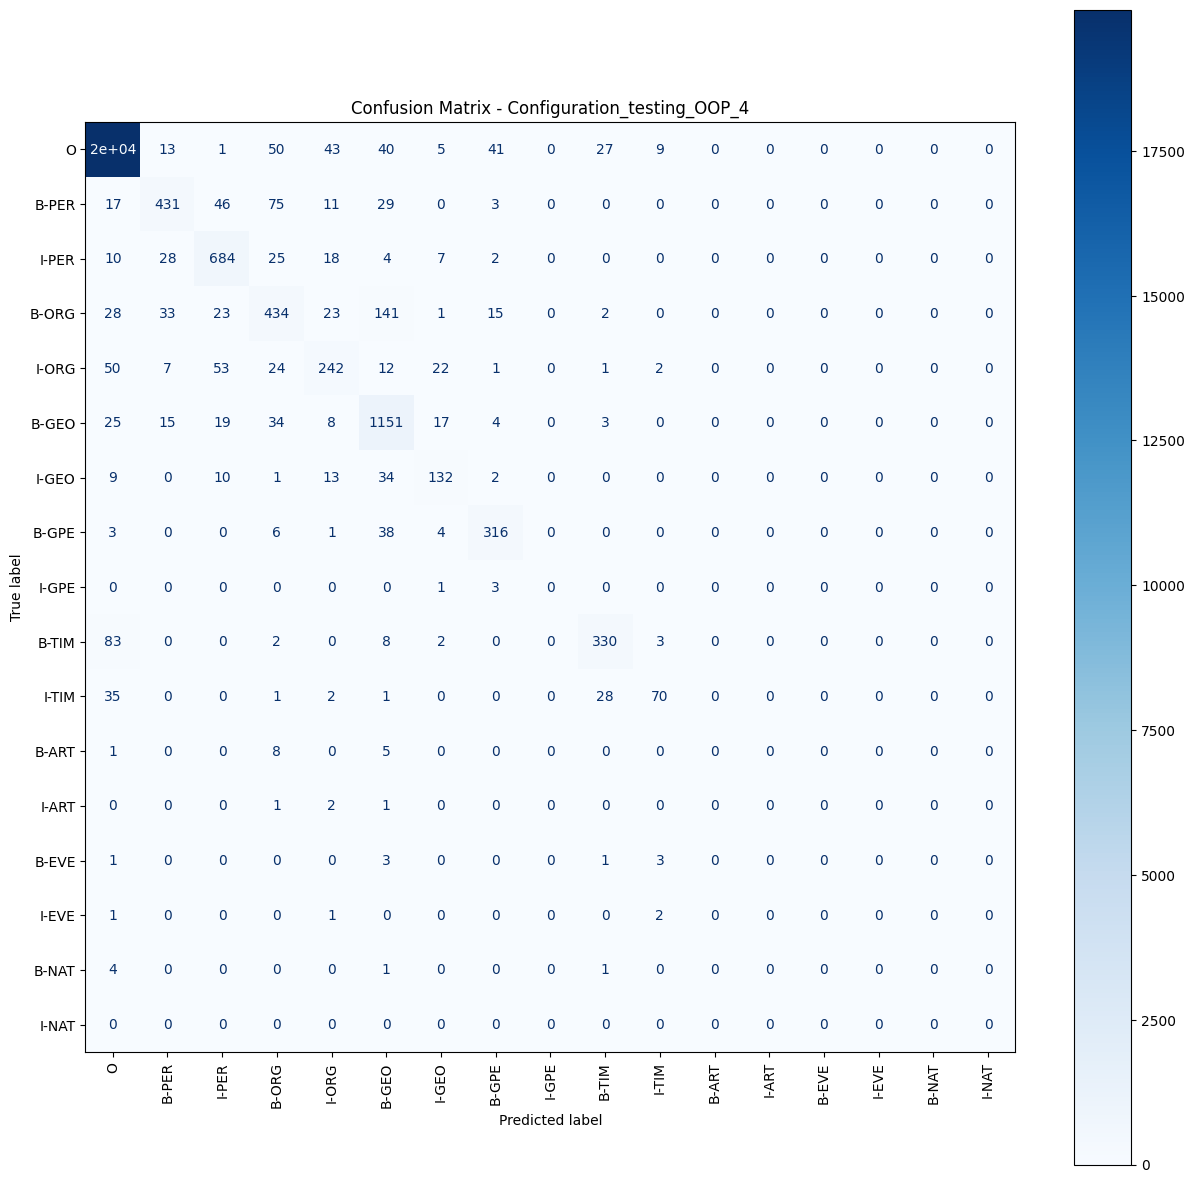


Per-Label Metrics:


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Label  Precision  Recall  F1-score  Accuracy     TP   FP   FN     TN
0       O          0       0         0  0.980256  19939  267  229   4687
1   B-PER          0       0         0  0.988974    431   96  181  24414
2   I-PER          0       0         0  0.990208    684  152   94  24192
3   B-ORG          0       0         0  0.980376    434  227  266  24195
4   I-ORG          0       0         0  0.988297    242  122  172  24586
5   B-GEO          0       0         0  0.982406   1151  317  125  23529
6   I-GEO          0       0         0  0.994905    132   59   69  24862
7   B-GPE          0       0         0  0.995104    316   71   52  24683
8   I-GPE          0       0         0  0.999841      0    0    4  25118
9   B-TIM          0       0         0  0.993591    330   63   98  24631
10  I-TIM          0       0         0  0.996577     70   19   67  24966
11  B-ART          0       0         0  0.999443      0    0   14  25108
12  I-ART          0       0         0  0.999841      0    0    4  25118
13  B-EVE          0       0         0  0.999682      0    0    8  25114
14  I-EVE          0       0         0  0.999841      0    0    4  25118
15  B-NAT          0       0         0  0.999761      0    0    6  25116
16  I-NAT          0       0         0  1.000000      0    0    0  25122


Overall Metrics:


Metric          Value
0  Precision       0.711869
1     Recall       0.740035
2   F1-score       0.725679
3   Accuracy       0.944551
4         TP   23729.000000
5         FP    1393.000000
6         FN    1393.000000
7         TN  400559.000000

In [ ]:
trainer = trainer_class.train_model(5e-5, 16, 2, "Configuration_testing_OOP_4")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Configuration_testing_OOP_4")
metrics.generate_confusion_matrix(trainer, datasets, "Configuration_testing_OOP_4")

In [ ]:
# Testing

trainer = train_model(5e-5, 16, 2, "Testing Configuration")
generate_confusion_matrix(trainer, "Testing Configuration")
upload_model_to_huggingface(model, tokenizer, "Testing Configuration")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_I...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Error creating repository: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-67d9895a-4588b54402e3f16418a54dac;4d65917a-0c3d-4d35-b41a-d1519a57bd19)

You already created this model repo


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_I-model
Generating Confusion Matrix for Final_Configuration_I...


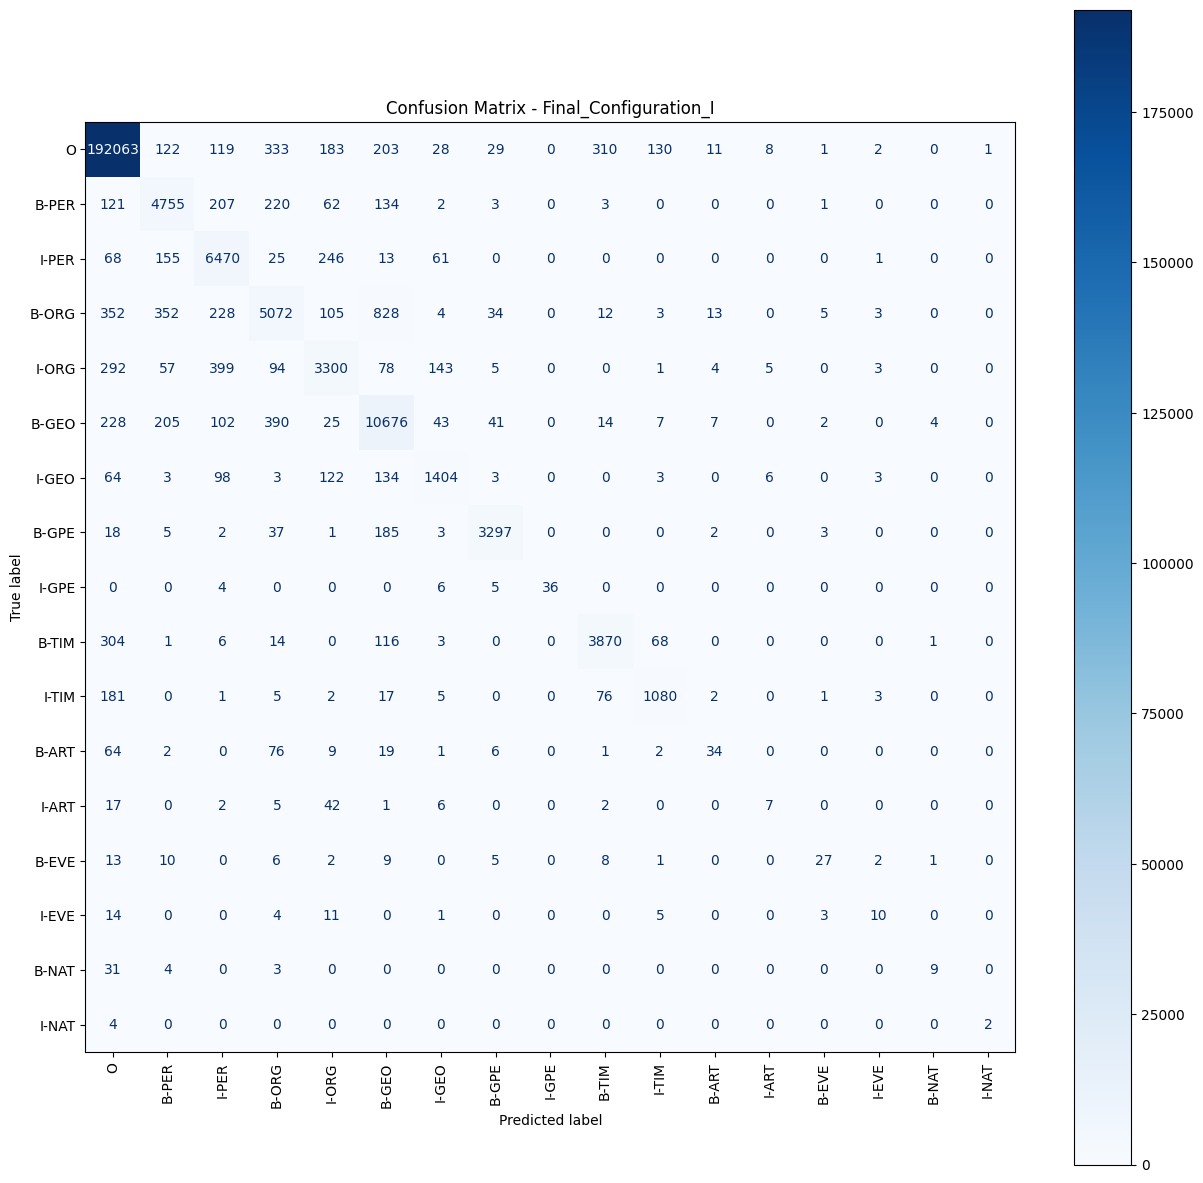


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986505  192063  1771  1480   45596
1   B-PER          0       0         0  0.993072    4755   916   753  234486
2   I-PER          0       0         0  0.992790    6470  1168   569  232703
3   B-ORG          0       0         0  0.986908    5072  1215  1939  232684
4   I-ORG          0       0         0  0.992151    3300   810  1081  235719
5   B-GEO          0       0         0  0.988357   10676  1737  1068  227429
6   I-GEO          0       0         0  0.996908    1404   306   439  238761
7   B-GPE          0       0         0  0.998394    3297   131   256  237226
8   I-GPE          0       0         0  0.999938      36     0    15  240859
9   B-TIM          0       0         0  0.996102    3870   426   513  236101
10  I-TIM          0       0         0  0.997871    1080   220   293  239317
11  B-ART          0       0         0  0.999091      34    39   180  240657
12  I-ART          0       0         0  0.999610       7    19    75  240809
13  B-EVE          0       0         0  0.999697      27    16    57  240810
14  I-EVE          0       0         0  0.999772      10    17    38  240845
15  B-NAT          0       0         0  0.999817       9     6    38  240857
16  I-NAT          0       0         0  0.999979       2     1     4  240903


Overall Metrics:


Metric         Value
0  Precision  8.309368e-01
1     Recall  8.345624e-01
2   F1-score  8.327457e-01
3   Accuracy  9.634801e-01
4         TP  2.321120e+05
5         FP  8.798000e+03
6         FN  8.798000e+03
7         TN  3.845762e+06

In [ ]:
# Configuration I
# learning rate = 5e-5, batch size = 16, epoch = 2

trainer = trainer_class.train_model(5e-5, 16, 2, "Final_Configuration_I")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_I")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_I")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_II...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_II-model
Generating Confusion Matrix for Final_Configuration_II...


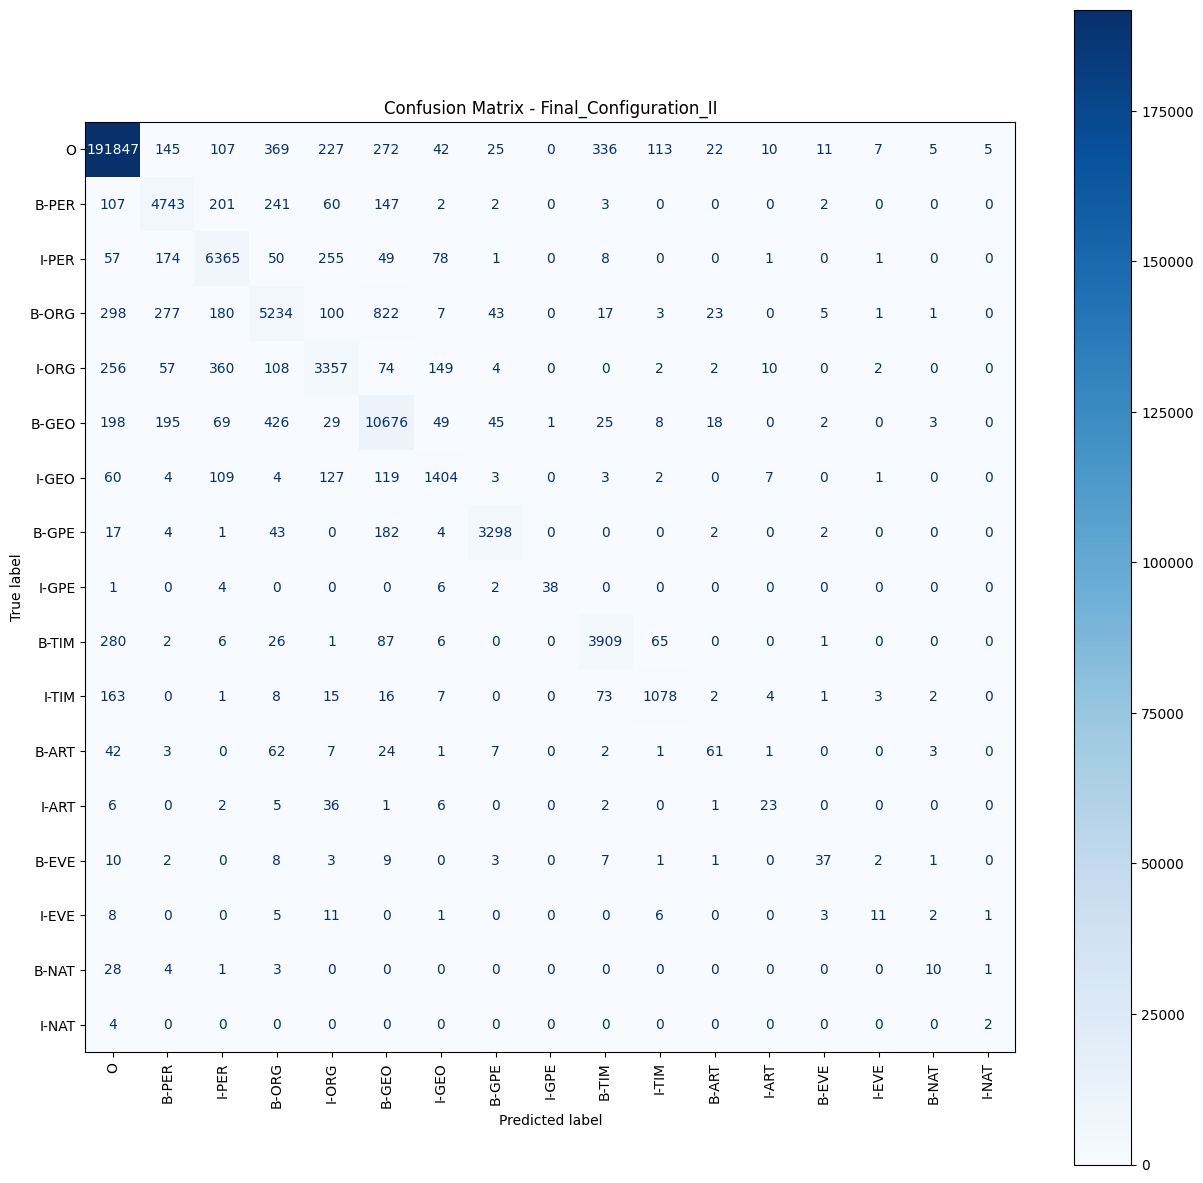


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986588  191847  1535  1696   45832
1   B-PER          0       0         0  0.993226    4743   867   765  234535
2   I-PER          0       0         0  0.992881    6365  1041   674  232830
3   B-ORG          0       0         0  0.986987    5234  1358  1777  232541
4   I-ORG          0       0         0  0.992134    3357   871  1024  235658
5   B-GEO          0       0         0  0.988087   10676  1802  1068  227364
6   I-GEO          0       0         0  0.996692    1404   358   439  238709
7   B-GPE          0       0         0  0.998381    3298   135   255  237222
8   I-GPE          0       0         0  0.999942      38     1    13  240858
9   B-TIM          0       0         0  0.996057    3909   476   474  236051
10  I-TIM          0       0         0  0.997941    1078   201   295  239336
11  B-ART          0       0         0  0.999070      61    71   153  240625
12  I-ART          0       0         0  0.999618      23    33    59  240795
13  B-EVE          0       0         0  0.999693      37    27    47  240799
14  I-EVE          0       0         0  0.999776      11    17    37  240845
15  B-NAT          0       0         0  0.999776      10    17    37  240846
16  I-NAT          0       0         0  0.999954       2     7     4  240897


Overall Metrics:


Metric         Value
0  Precision  8.260607e-01
1     Recall  8.411382e-01
2   F1-score  8.335313e-01
3   Accuracy  9.634013e-01
4         TP  2.320930e+05
5         FP  8.817000e+03
6         FN  8.817000e+03
7         TN  3.845743e+06

In [ ]:
# Configuration II
# learning rate = 5e-5, batch size = 16, epoch = 3

trainer = trainer_class.train_model(5e-5, 16, 3, "Final_Configuration_II")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_II")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_II")

Training Final_Configuration_III...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_III-model
Generating Confusion Matrix for Final_Configuration_III...


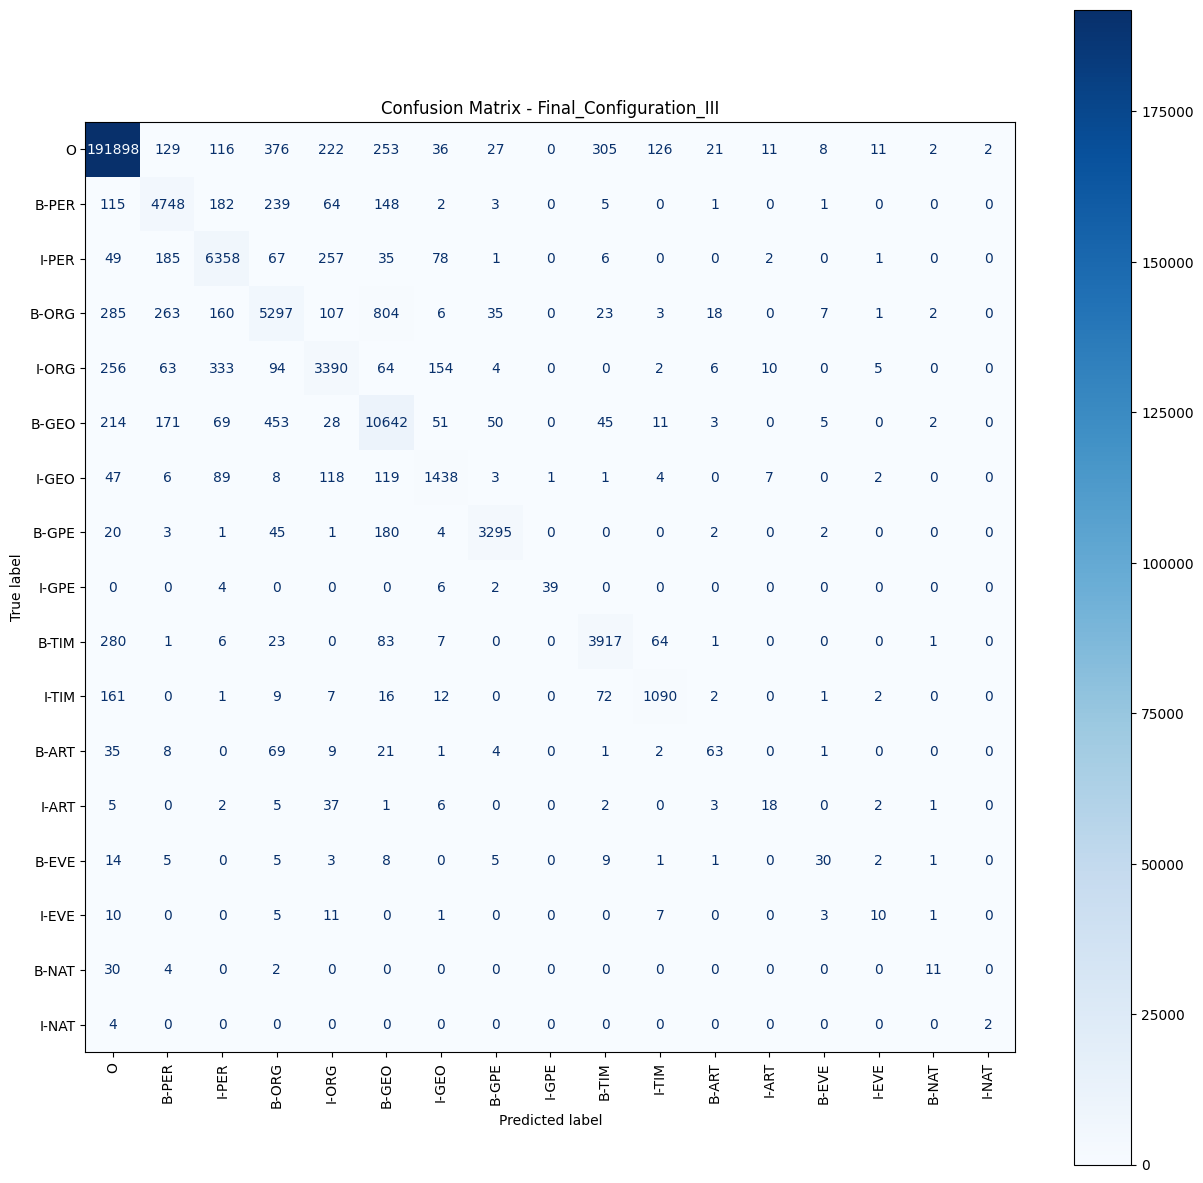


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986842  191898  1525  1645   45842
1   B-PER          0       0         0  0.993367    4748   838   760  234564
2   I-PER          0       0         0  0.993176    6358   963   681  232908
3   B-ORG          0       0         0  0.987074    5297  1400  1714  232499
4   I-ORG          0       0         0  0.992300    3390   864   991  235665
5   B-GEO          0       0         0  0.988236   10642  1732  1102  227434
6   I-GEO          0       0         0  0.996808    1438   364   405  238703
7   B-GPE          0       0         0  0.998373    3295   134   258  237223
8   I-GPE          0       0         0  0.999946      39     1    12  240858
9   B-TIM          0       0         0  0.996119    3917   469   466  236058
10  I-TIM          0       0         0  0.997912    1090   220   283  239317
11  B-ART          0       0         0  0.999132      63    58   151  240638
12  I-ART          0       0         0  0.999610      18    30    64  240798
13  B-EVE          0       0         0  0.999660      30    28    54  240798
14  I-EVE          0       0         0  0.999734      10    26    38  240836
15  B-NAT          0       0         0  0.999809      11    10    36  240853
16  I-NAT          0       0         0  0.999975       2     2     4  240902


Overall Metrics:


Metric         Value
0  Precision  8.300036e-01
1     Recall  8.425516e-01
2   F1-score  8.362306e-01
3   Accuracy  9.640364e-01
4         TP  2.322460e+05
5         FP  8.664000e+03
6         FN  8.664000e+03
7         TN  3.845896e+06

In [ ]:
# Configuration III
# learning rate = 5e-5, batch size = 16, epoch = 4

trainer = trainer_class.train_model(5e-5, 16, 4, "Final_Configuration_III")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_III")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_III")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_IV...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_IV-model
Generating Confusion Matrix for Final_Configuration_IV...


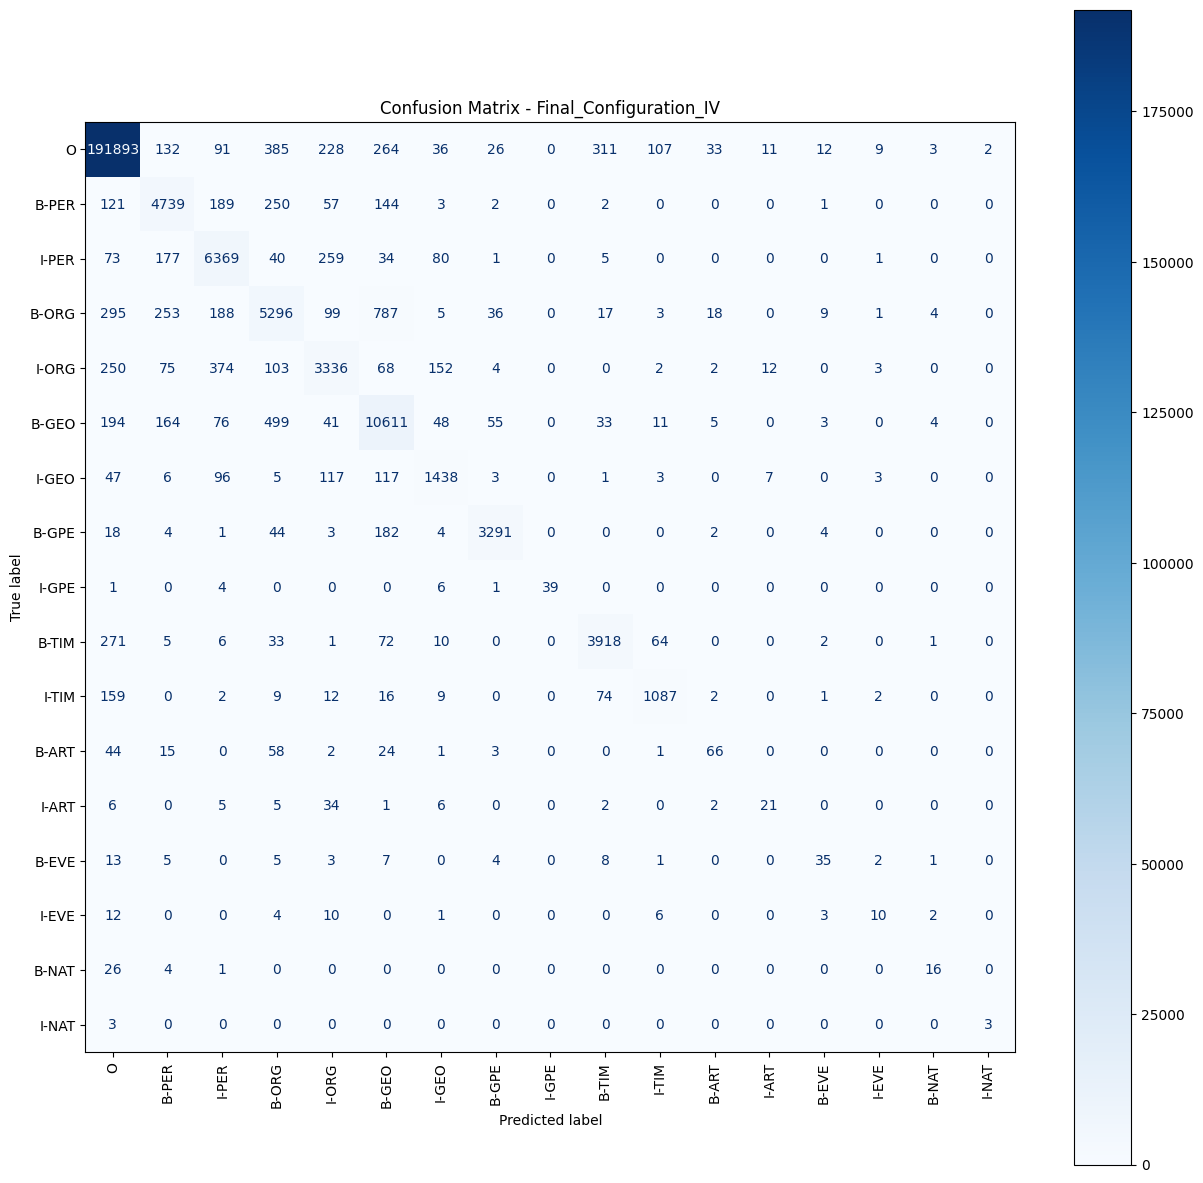


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986788  191893  1533  1650   45834
1   B-PER          0       0         0  0.993321    4739   840   769  234562
2   I-PER          0       0         0  0.992931    6369  1033   670  232838
3   B-ORG          0       0         0  0.986904    5296  1440  1715  232459
4   I-ORG          0       0         0  0.992068    3336   866  1045  235663
5   B-GEO          0       0         0  0.988174   10611  1716  1133  227450
6   I-GEO          0       0         0  0.996820    1438   361   405  238706
7   B-GPE          0       0         0  0.998352    3291   135   262  237222
8   I-GPE          0       0         0  0.999950      39     0    12  240859
9   B-TIM          0       0         0  0.996189    3918   453   465  236074
10  I-TIM          0       0         0  0.997991    1087   198   286  239339
11  B-ART          0       0         0  0.999120      66    64   148  240632
12  I-ART          0       0         0  0.999622      21    30    61  240798
13  B-EVE          0       0         0  0.999651      35    35    49  240791
14  I-EVE          0       0         0  0.999755      10    21    38  240841
15  B-NAT          0       0         0  0.999809      16    15    31  240848
16  I-NAT          0       0         0  0.999979       3     2     3  240902


Overall Metrics:


Metric         Value
0  Precision  8.311456e-01
1     Recall  8.424594e-01
2   F1-score  8.367643e-01
3   Accuracy  9.637126e-01
4         TP  2.321680e+05
5         FP  8.742000e+03
6         FN  8.742000e+03
7         TN  3.845818e+06

In [ ]:
# Configuration IV
# learning rate = 5e-5, batch size = 32, epoch = 2

trainer = trainer_class.train_model(5e-5, 32, 2, "Final_Configuration_IV")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_IV")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_IV")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_V...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_V-model
Generating Confusion Matrix for Final_Configuration_V...


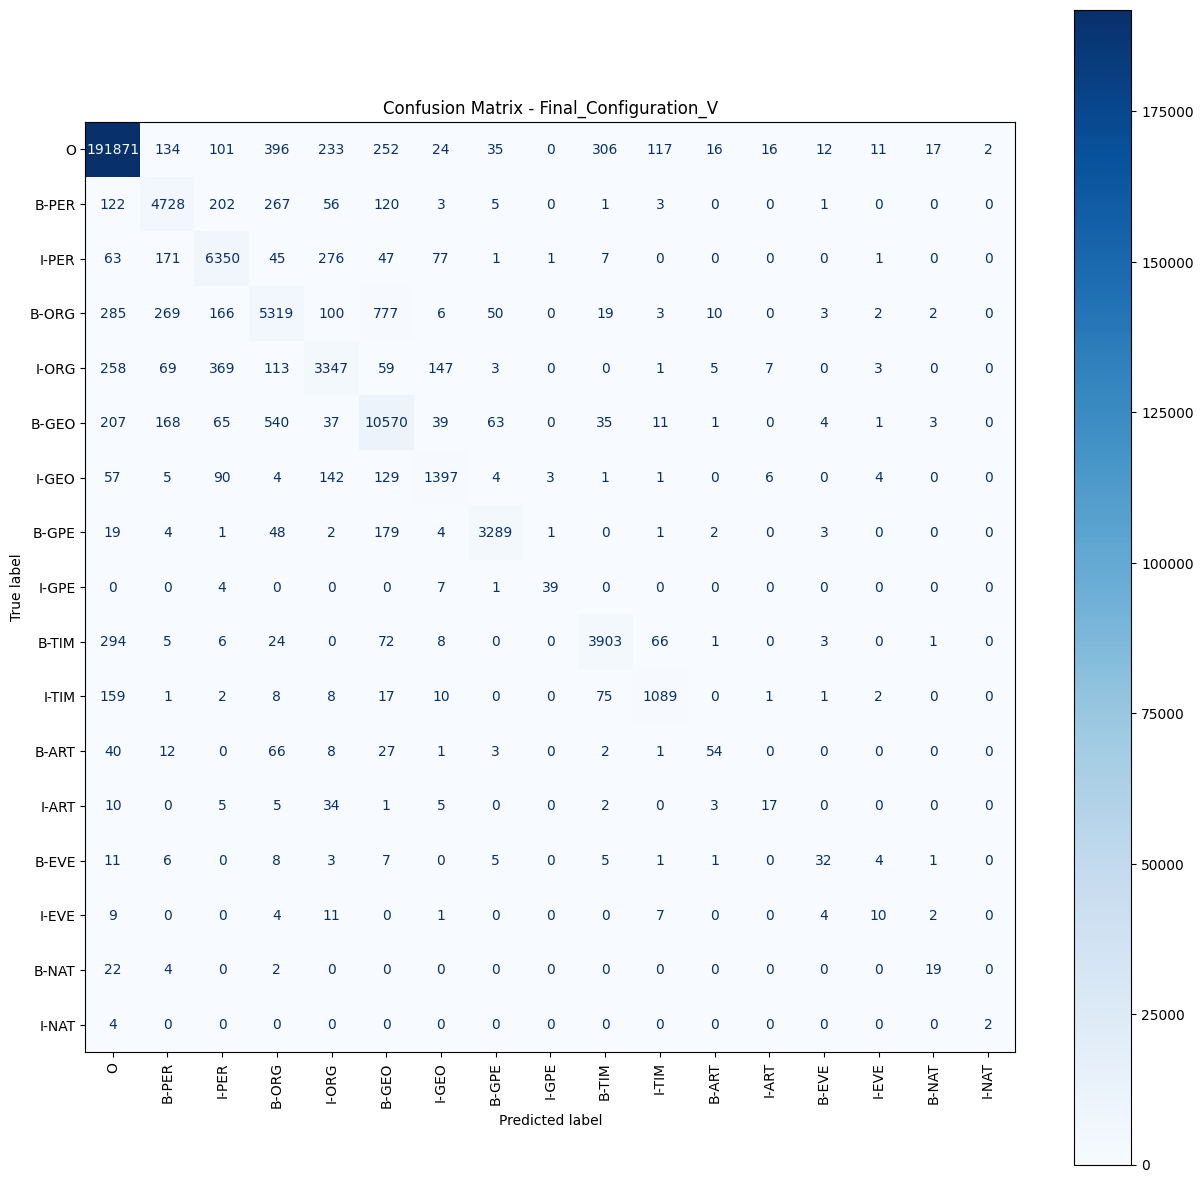


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986584  191871  1560  1672   45807
1   B-PER          0       0         0  0.993242    4728   848   780  234554
2   I-PER          0       0         0  0.992943    6350  1011   689  232860
3   B-ORG          0       0         0  0.986626    5319  1530  1692  232369
4   I-ORG          0       0         0  0.991931    3347   910  1034  235619
5   B-GEO          0       0         0  0.988124   10570  1687  1174  227479
6   I-GEO          0       0         0  0.996771    1397   332   446  238735
7   B-GPE          0       0         0  0.998198    3289   170   264  237187
8   I-GPE          0       0         0  0.999929      39     5    12  240854
9   B-TIM          0       0         0  0.996127    3903   453   480  236074
10  I-TIM          0       0         0  0.997941    1089   212   284  239325
11  B-ART          0       0         0  0.999174      54    39   160  240657
12  I-ART          0       0         0  0.999606      17    30    65  240798
13  B-EVE          0       0         0  0.999655      32    31    52  240795
14  I-EVE          0       0         0  0.999726      10    28    38  240834
15  B-NAT          0       0         0  0.999776      19    26    28  240837
16  I-NAT          0       0         0  0.999975       2     2     4  240902


Overall Metrics:


Metric         Value
0  Precision  8.283682e-01
1     Recall  8.407387e-01
2   F1-score  8.345076e-01
3   Accuracy  9.631647e-01
4         TP  2.320360e+05
5         FP  8.874000e+03
6         FN  8.874000e+03
7         TN  3.845686e+06

In [ ]:
# Configuration V
# learning rate = 5e-5, batch size = 32, epoch = 3

trainer = trainer_class.train_model(5e-5, 32, 3, "Final_Configuration_V")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_V")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_V")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VI...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_VI-model
Generating Confusion Matrix for Final_Configuration_VI...


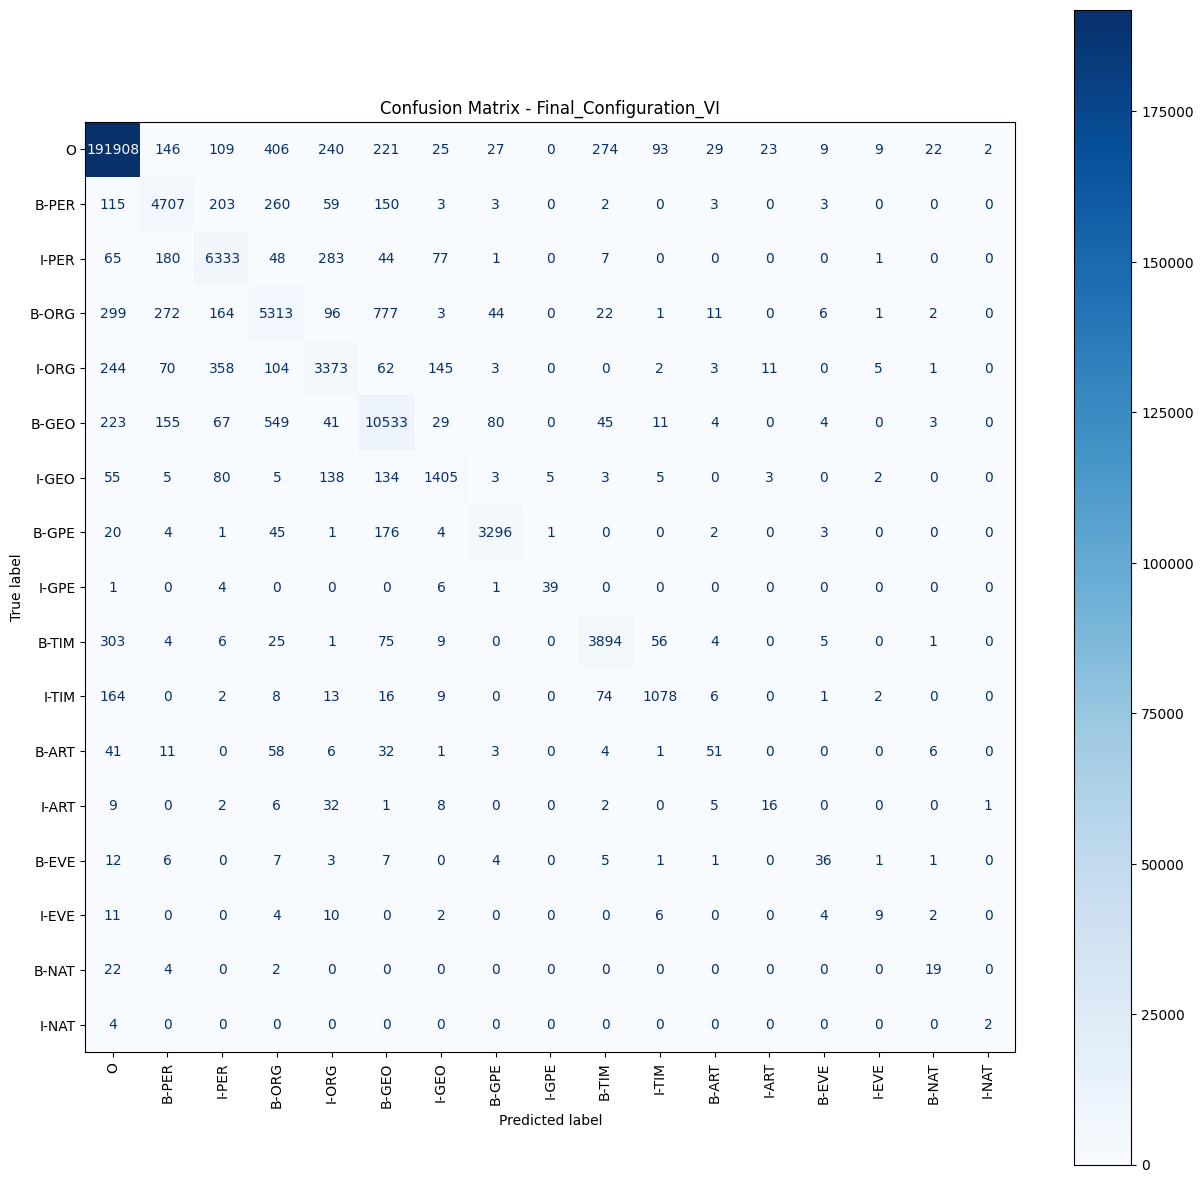


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986622  191908  1588  1635   45779
1   B-PER          0       0         0  0.993118    4707   857   801  234545
2   I-PER          0       0         0  0.992935    6333   996   706  232875
3   B-ORG          0       0         0  0.986613    5313  1527  1698  232372
4   I-ORG          0       0         0  0.991985    3373   923  1008  235606
5   B-GEO          0       0         0  0.987937   10533  1695  1211  227471
6   I-GEO          0       0         0  0.996849    1405   321   438  238746
7   B-GPE          0       0         0  0.998232    3296   169   257  237188
8   I-GPE          0       0         0  0.999925      39     6    12  240853
9   B-TIM          0       0         0  0.996152    3894   438   489  236089
10  I-TIM          0       0         0  0.998045    1078   176   295  239361
11  B-ART          0       0         0  0.999041      51    68   163  240628
12  I-ART          0       0         0  0.999572      16    37    66  240791
13  B-EVE          0       0         0  0.999655      36    35    48  240791
14  I-EVE          0       0         0  0.999751       9    21    39  240841
15  B-NAT          0       0         0  0.999726      19    38    28  240825
16  I-NAT          0       0         0  0.999971       2     3     4  240901


Overall Metrics:


Metric         Value
0  Precision  8.280065e-01
1     Recall  8.390487e-01
2   F1-score  8.334910e-01
3   Accuracy  9.630650e-01
4         TP  2.320120e+05
5         FP  8.898000e+03
6         FN  8.898000e+03
7         TN  3.845662e+06

In [ ]:
# Configuration VI
# learning rate = 5e-5, batch size = 32, epoch = 4

trainer = trainer_class.train_model(5e-5, 32, 4, "Final_Configuration_VI")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_VI")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_VI")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VII...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_VII-model
Generating Confusion Matrix for Final_Configuration_VII...


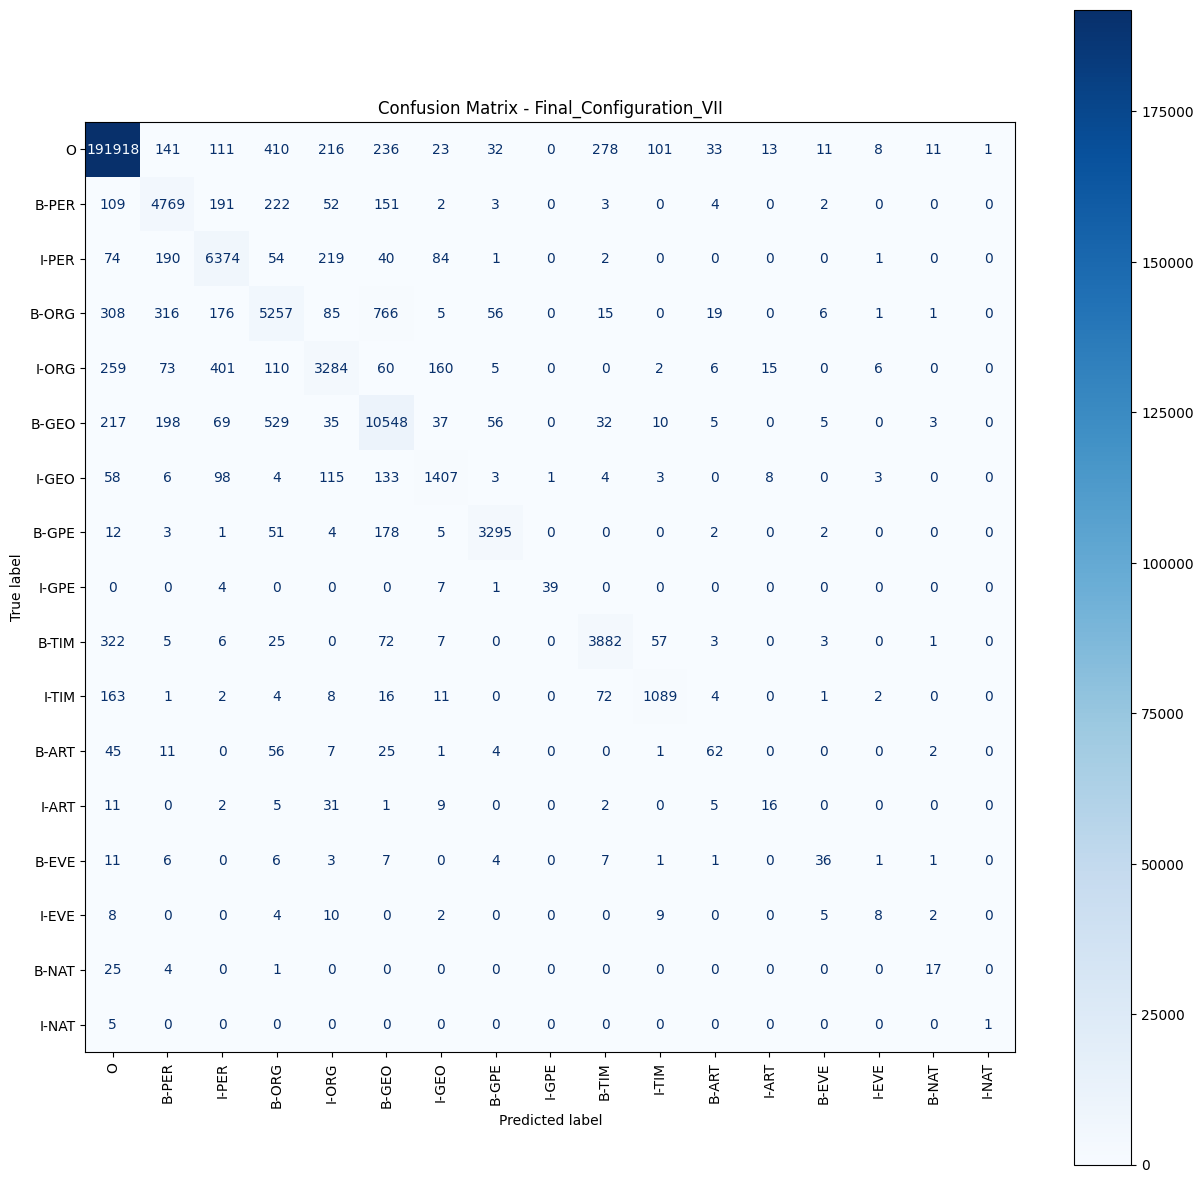


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986501  191918  1627  1625   45740
1   B-PER          0       0         0  0.992972    4769   954   739  234448
2   I-PER          0       0         0  0.992835    6374  1061   665  232810
3   B-ORG          0       0         0  0.986572    5257  1481  1754  232418
4   I-ORG          0       0         0  0.992188    3284   785  1097  235744
5   B-GEO          0       0         0  0.988041   10548  1685  1196  227481
6   I-GEO          0       0         0  0.996725    1407   353   436  238714
7   B-GPE          0       0         0  0.998244    3295   165   258  237192
8   I-GPE          0       0         0  0.999946      39     1    12  240858
9   B-TIM          0       0         0  0.996198    3882   415   501  236112
10  I-TIM          0       0         0  0.998057    1089   184   284  239353
11  B-ART          0       0         0  0.999029      62    82   152  240614
12  I-ART          0       0         0  0.999577      16    36    66  240792
13  B-EVE          0       0         0  0.999655      36    35    48  240791
14  I-EVE          0       0         0  0.999743       8    22    40  240840
15  B-NAT          0       0         0  0.999788      17    21    30  240842
16  I-NAT          0       0         0  0.999975       1     1     5  240903


Overall Metrics:


Metric         Value
0  Precision  8.281307e-01
1     Recall  8.396325e-01
2   F1-score  8.338419e-01
3   Accuracy  9.630235e-01
4         TP  2.320020e+05
5         FP  8.908000e+03
6         FN  8.908000e+03
7         TN  3.845652e+06

In [ ]:
# Configuration VII
# learning rate = 3e-5, batch size = 16, epoch = 2

trainer = trainer_class.train_model(3e-5, 16, 2, "Final_Configuration_VII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_VII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_VII")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VIII...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_VIII-model
Generating Confusion Matrix for Final_Configuration_VIII...


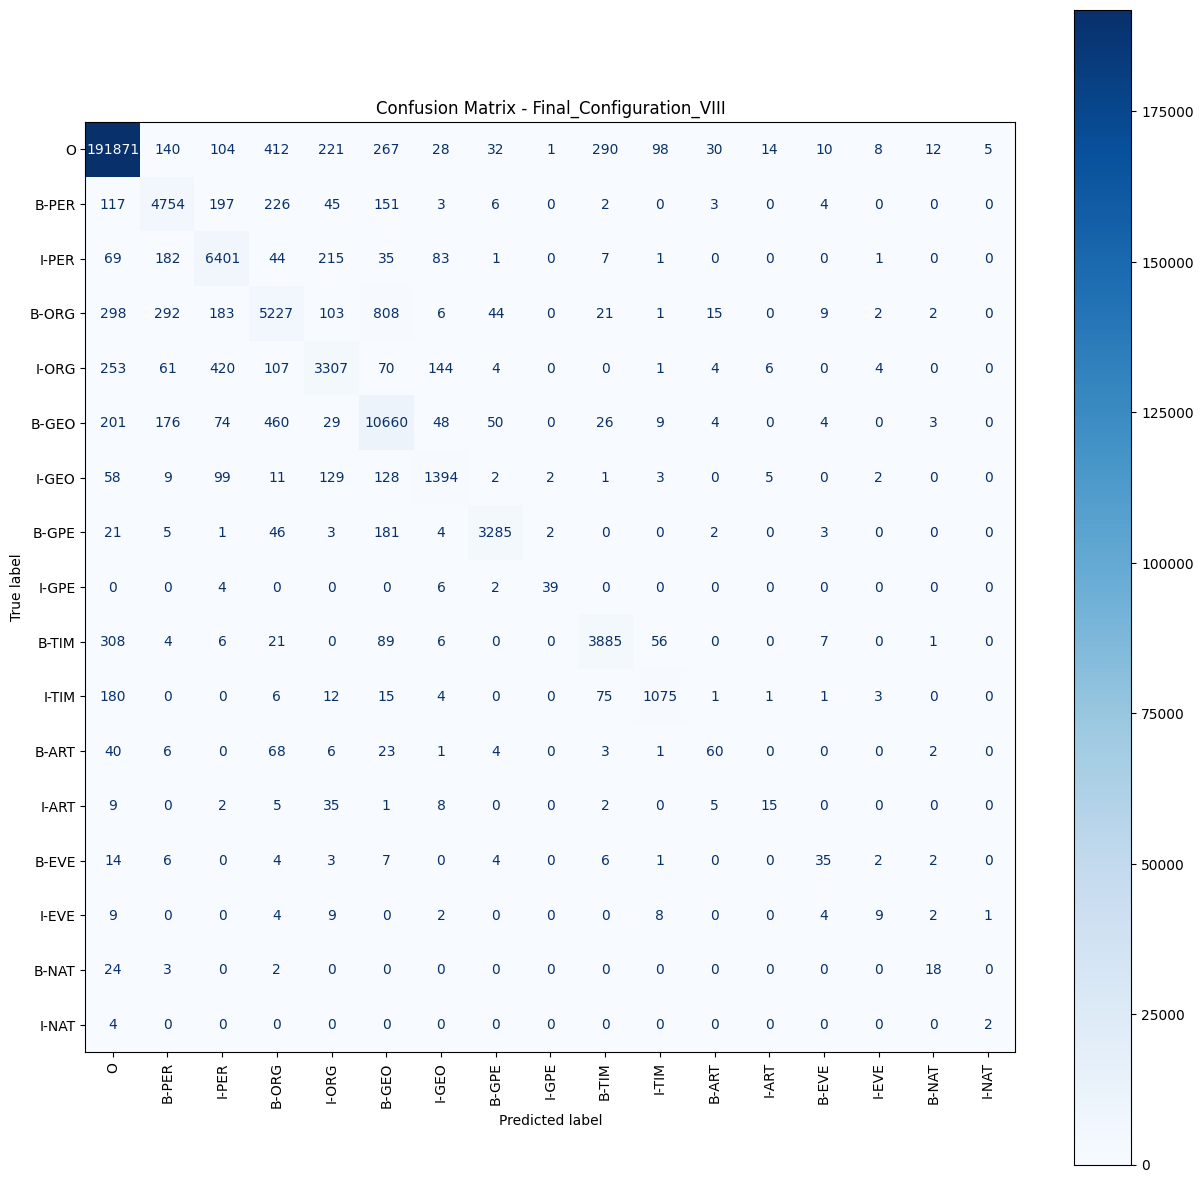


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986397  191871  1605  1672   45762
1   B-PER          0       0         0  0.993201    4754   884   754  234518
2   I-PER          0       0         0  0.992827    6401  1090   638  232781
3   B-ORG          0       0         0  0.986717    5227  1416  1784  232483
4   I-ORG          0       0         0  0.992180    3307   810  1074  235719
5   B-GEO          0       0         0  0.988132   10660  1775  1084  227391
6   I-GEO          0       0         0  0.996712    1394   343   449  238724
7   B-GPE          0       0         0  0.998269    3285   149   268  237208
8   I-GPE          0       0         0  0.999929      39     5    12  240854
9   B-TIM          0       0         0  0.996135    3885   433   498  236094
10  I-TIM          0       0         0  0.998020    1075   179   298  239358
11  B-ART          0       0         0  0.999095      60    64   154  240632
12  I-ART          0       0         0  0.999614      15    26    67  240802
13  B-EVE          0       0         0  0.999622      35    42    49  240784
14  I-EVE          0       0         0  0.999747       9    22    39  240840
15  B-NAT          0       0         0  0.999780      18    24    29  240839
16  I-NAT          0       0         0  0.999958       2     6     4  240898


Overall Metrics:


Metric         Value
0  Precision  8.303225e-01
1     Recall  8.417527e-01
2   F1-score  8.359985e-01
3   Accuracy  9.631688e-01
4         TP  2.320370e+05
5         FP  8.873000e+03
6         FN  8.873000e+03
7         TN  3.845687e+06

In [ ]:
# Configuration VIII
# learning rate = 3e-5, batch size = 16, epoch = 3

trainer = trainer_class.train_model(3e-5, 16, 3, "Final_Configuration_VIII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_VIII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_VIII")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_IX...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_IX-model
Generating Confusion Matrix for Final_Configuration_IX...


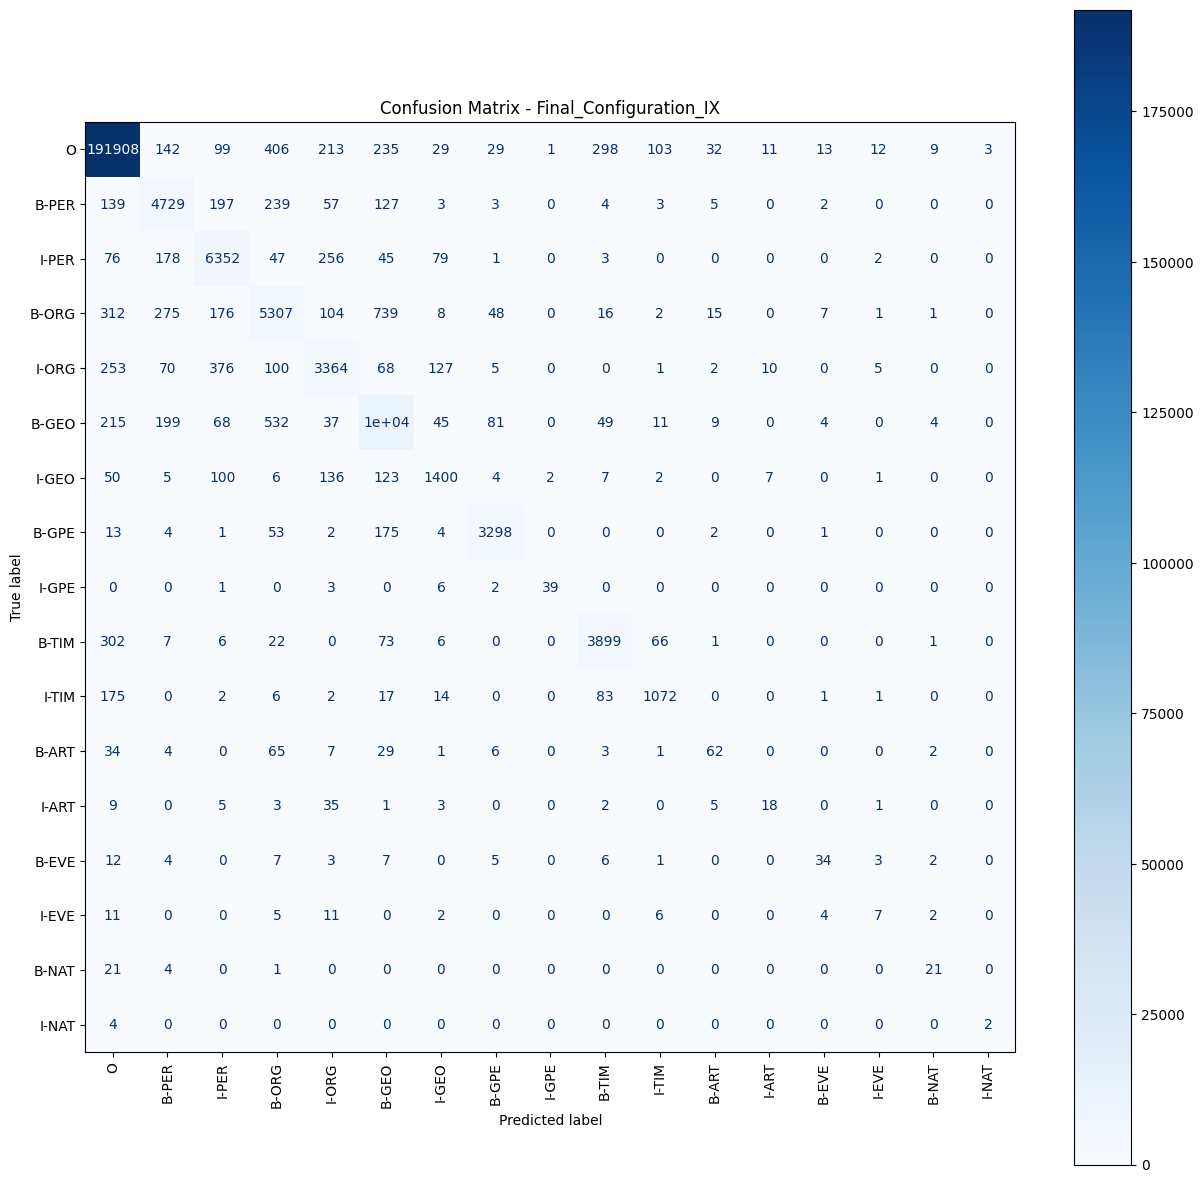


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986464  191908  1626  1635   45741
1   B-PER          0       0         0  0.993064    4729   892   779  234510
2   I-PER          0       0         0  0.992869    6352  1031   687  232840
3   B-ORG          0       0         0  0.986734    5307  1492  1704  232407
4   I-ORG          0       0         0  0.992184    3364   866  1017  235663
5   B-GEO          0       0         0  0.987991   10490  1639  1254  227527
6   I-GEO          0       0         0  0.996804    1400   327   443  238740
7   B-GPE          0       0         0  0.998178    3298   184   255  237173
8   I-GPE          0       0         0  0.999938      39     3    12  240856
9   B-TIM          0       0         0  0.996036    3899   471   484  236056
10  I-TIM          0       0         0  0.997937    1072   196   301  239341
11  B-ART          0       0         0  0.999074      62    71   152  240625
12  I-ART          0       0         0  0.999618      18    28    64  240800
13  B-EVE          0       0         0  0.999660      34    32    50  240794
14  I-EVE          0       0         0  0.999722       7    26    41  240836
15  B-NAT          0       0         0  0.999805      21    21    26  240842
16  I-NAT          0       0         0  0.999971       2     3     4  240901


Overall Metrics:


Metric         Value
0  Precision  8.303148e-01
1     Recall  8.396018e-01
2   F1-score  8.349325e-01
3   Accuracy  9.630235e-01
4         TP  2.320020e+05
5         FP  8.908000e+03
6         FN  8.908000e+03
7         TN  3.845652e+06

In [ ]:
# Configuration IX
# learning rate = 3e-5, batch size = 16, epoch = 4

trainer = trainer_class.train_model(3e-5, 16, 4, "Final_Configuration_IX")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_IX")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_IX")

Training Final_Configuration_X...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_X-model
Generating Confusion Matrix for Final_Configuration_X...


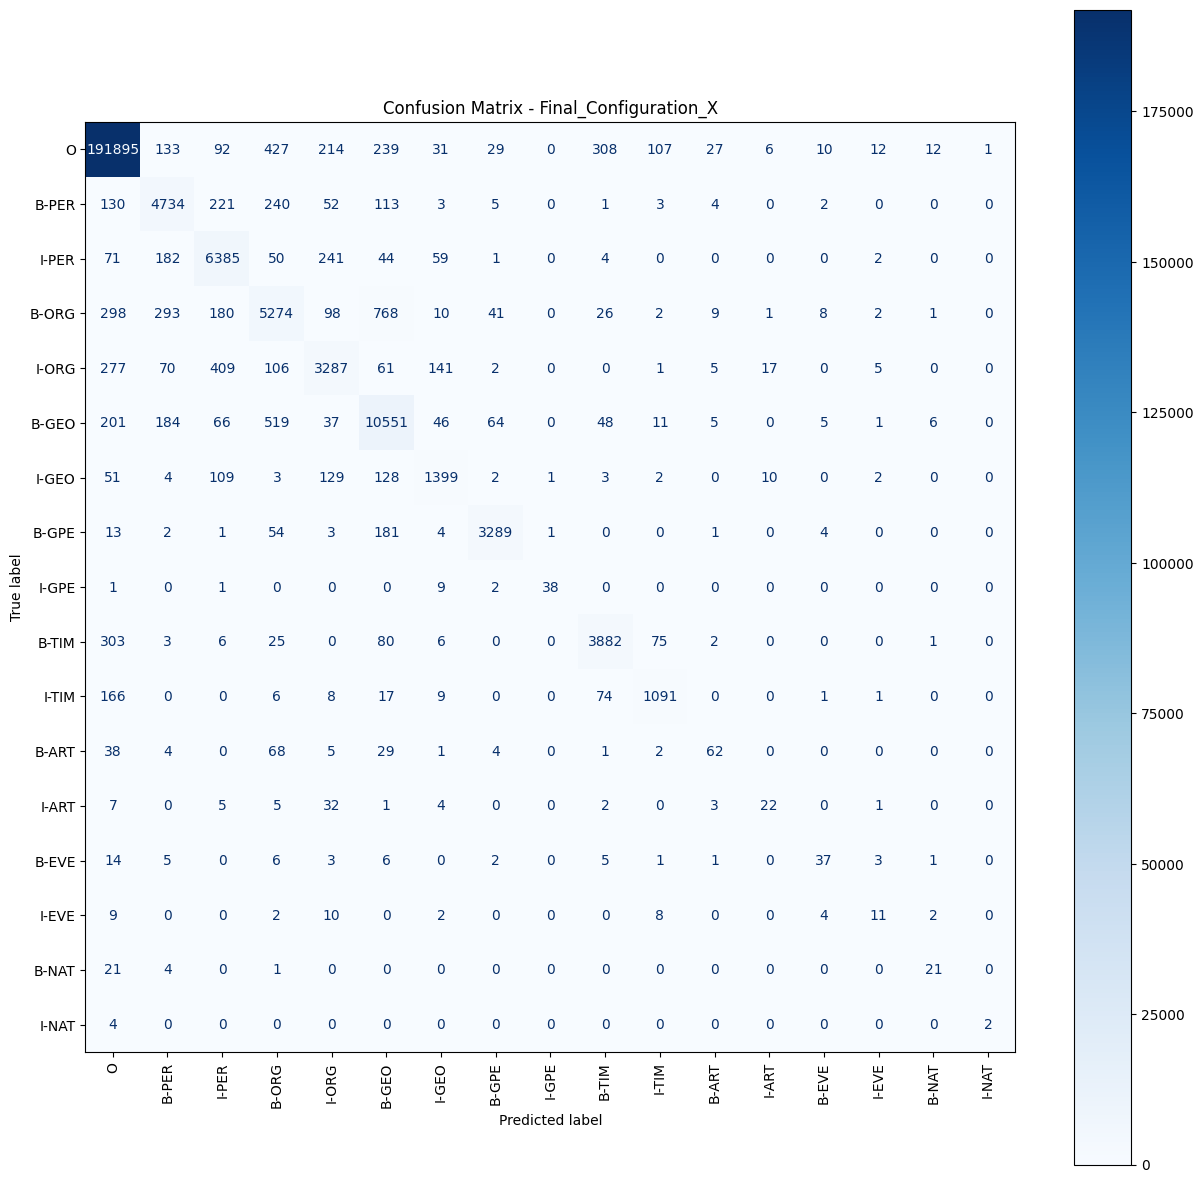


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986501  191895  1604  1648   45763
1   B-PER          0       0         0  0.993118    4734   884   774  234518
2   I-PER          0       0         0  0.992761    6385  1090   654  232781
3   B-ORG          0       0         0  0.986514    5274  1512  1737  232387
4   I-ORG          0       0         0  0.992005    3287   832  1094  235697
5   B-GEO          0       0         0  0.988128   10551  1667  1193  227499
6   I-GEO          0       0         0  0.996808    1399   325   444  238742
7   B-GPE          0       0         0  0.998273    3289   152   264  237205
8   I-GPE          0       0         0  0.999938      38     2    13  240857
9   B-TIM          0       0         0  0.995961    3882   472   501  236055
10  I-TIM          0       0         0  0.997949    1091   212   282  239325
11  B-ART          0       0         0  0.999132      62    57   152  240639
12  I-ART          0       0         0  0.999610      22    34    60  240794
13  B-EVE          0       0         0  0.999664      37    34    47  240792
14  I-EVE          0       0         0  0.999726      11    29    37  240833
15  B-NAT          0       0         0  0.999797      21    23    26  240840
16  I-NAT          0       0         0  0.999979       2     1     4  240903


Overall Metrics:


Metric         Value
0  Precision  8.309996e-01
1     Recall  8.406772e-01
2   F1-score  8.358104e-01
3   Accuracy  9.629322e-01
4         TP  2.319800e+05
5         FP  8.930000e+03
6         FN  8.930000e+03
7         TN  3.845630e+06

In [ ]:
# Configuration X
# learning rate = 3e-5, batch size = 32, epoch = 2

trainer = trainer_class.train_model(3e-5, 32, 2, "Final_Configuration_X")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_X")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_X")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_XI...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XI-model
Generating Confusion Matrix for Final_Configuration_XI...


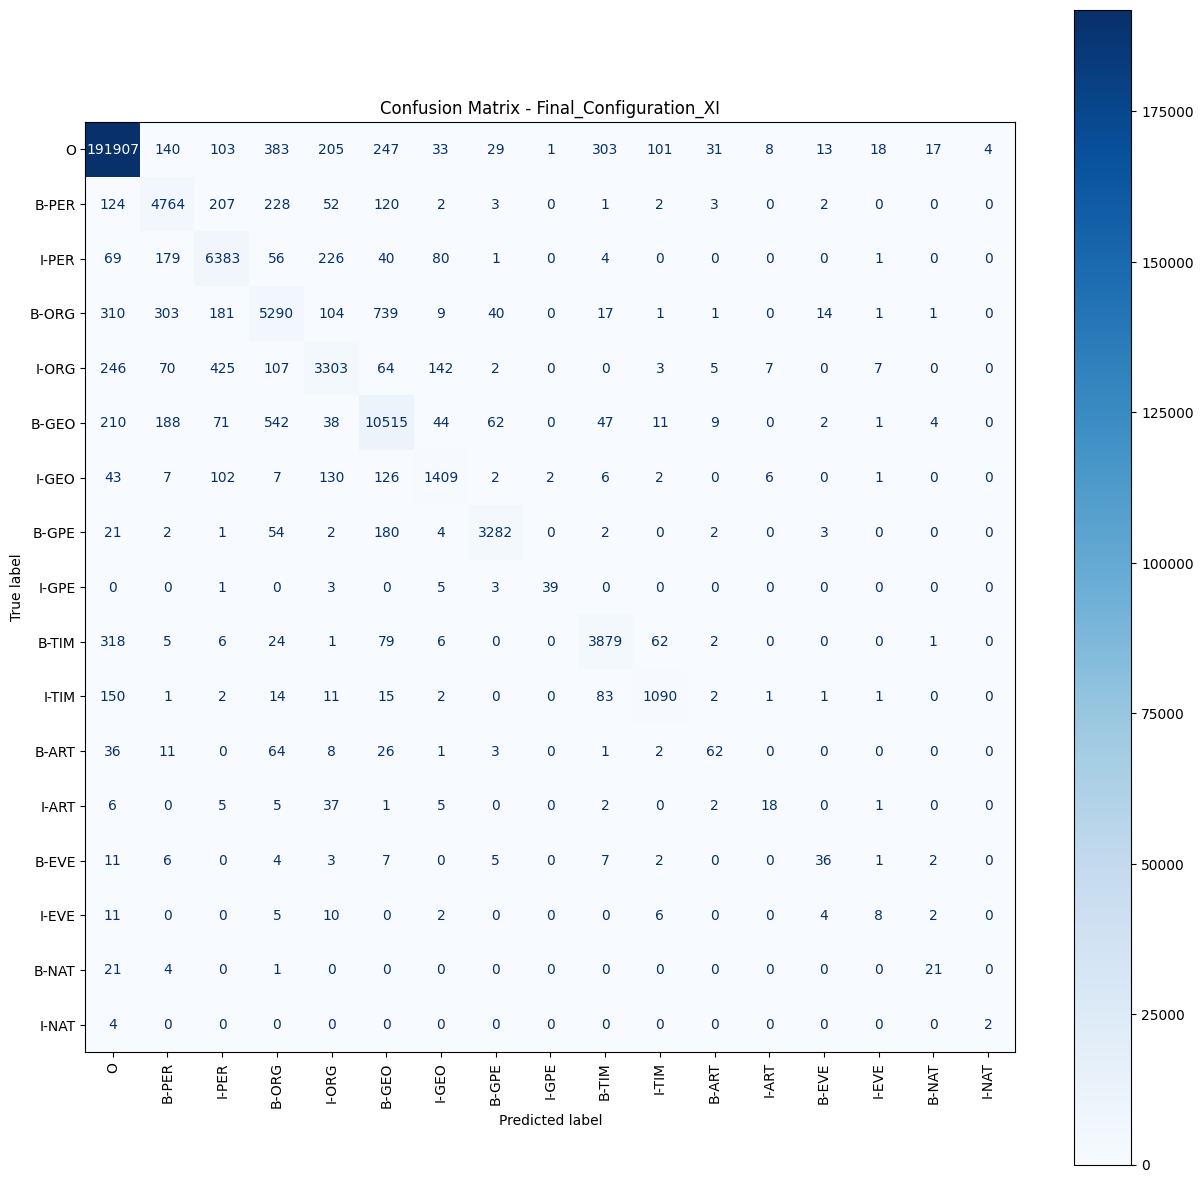


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986651  191907  1580  1636   45787
1   B-PER          0       0         0  0.993109    4764   916   744  234486
2   I-PER          0       0         0  0.992694    6383  1104   656  232767
3   B-ORG          0       0         0  0.986655    5290  1494  1721  232405
4   I-ORG          0       0         0  0.992080    3303   830  1078  235699
5   B-GEO          0       0         0  0.988074   10515  1644  1229  227522
6   I-GEO          0       0         0  0.996808    1409   335   434  238732
7   B-GPE          0       0         0  0.998252    3282   150   271  237207
8   I-GPE          0       0         0  0.999938      39     3    12  240856
9   B-TIM          0       0         0  0.995945    3879   473   504  236054
10  I-TIM          0       0         0  0.998028    1090   192   283  239345
11  B-ART          0       0         0  0.999132      62    57   152  240639
12  I-ART          0       0         0  0.999643      18    22    64  240806
13  B-EVE          0       0         0  0.999639      36    39    48  240787
14  I-EVE          0       0         0  0.999701       8    32    40  240830
15  B-NAT          0       0         0  0.999780      21    27    26  240836
16  I-NAT          0       0         0  0.999967       2     4     4  240900


Overall Metrics:


Metric         Value
0  Precision  8.298421e-01
1     Recall  8.399398e-01
2   F1-score  8.348604e-01
3   Accuracy  9.630484e-01
4         TP  2.320080e+05
5         FP  8.902000e+03
6         FN  8.902000e+03
7         TN  3.845658e+06

In [ ]:
# Configuration XI
# learning rate = 3e-5, batch size = 32, epoch = 3

trainer = trainer_class.train_model(3e-5, 32, 3, "Final_Configuration_XI")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XI")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XI")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_XII...


<ipython-input-5-bddc84c01238>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XII-model
Generating Confusion Matrix for Final_Configuration_XII...


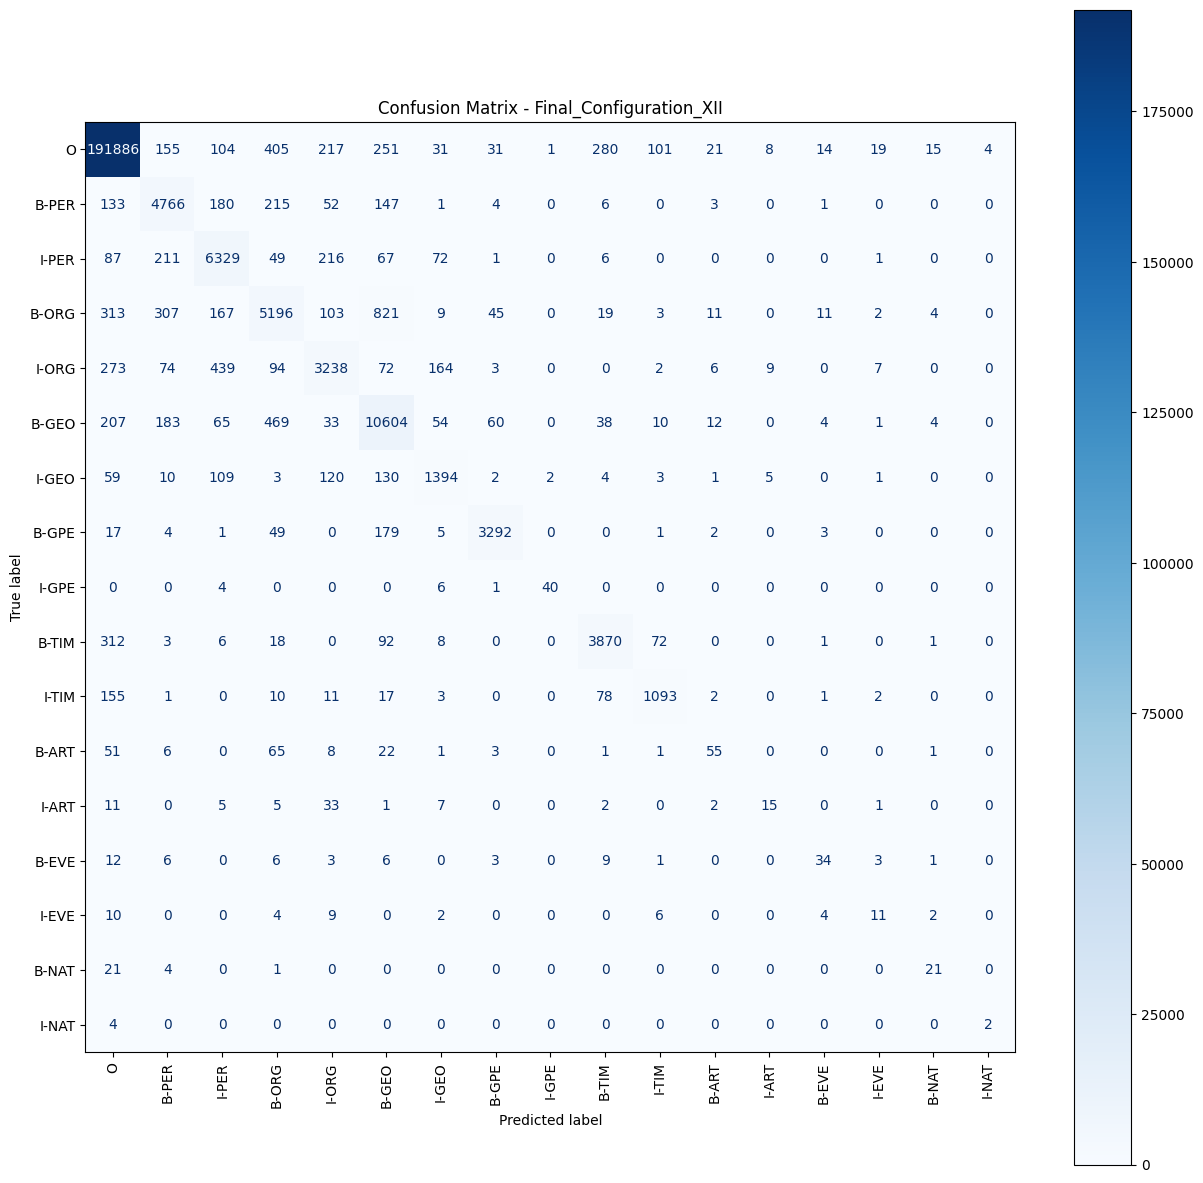


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986211  191886  1665  1657   45702
1   B-PER          0       0         0  0.992919    4766   964   742  234438
2   I-PER          0       0         0  0.992570    6329  1080   710  232791
3   B-ORG          0       0         0  0.986684    5196  1393  1815  232506
4   I-ORG          0       0         0  0.991914    3238   805  1143  235724
5   B-GEO          0       0         0  0.987776   10604  1805  1140  227361
6   I-GEO          0       0         0  0.996629    1394   363   449  238704
7   B-GPE          0       0         0  0.998282    3292   153   261  237204
8   I-GPE          0       0         0  0.999942      40     3    11  240856
9   B-TIM          0       0         0  0.996032    3870   443   513  236084
10  I-TIM          0       0         0  0.998008    1093   200   280  239337
11  B-ART          0       0         0  0.999091      55    60   159  240636
12  I-ART          0       0         0  0.999631      15    22    67  240806
13  B-EVE          0       0         0  0.999631      34    39    50  240787
14  I-EVE          0       0         0  0.999693      11    37    37  240825
15  B-NAT          0       0         0  0.999776      21    28    26  240835
16  I-NAT          0       0         0  0.999967       2     4     4  240900


Overall Metrics:


Metric         Value
0  Precision  8.274567e-01
1     Recall  8.393559e-01
2   F1-score  8.333638e-01
3   Accuracy  9.623760e-01
4         TP  2.318460e+05
5         FP  9.064000e+03
6         FN  9.064000e+03
7         TN  3.845496e+06

In [ ]:
# Configuration XII
# learning rate = 3e-5, batch size = 32, epoch = 4

trainer = trainer_class.train_model(3e-5, 32, 4, "Final_Configuration_XII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XII")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_XIII...


<ipython-input-34-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XIII-model
Generating Confusion Matrix for Final_Configuration_XIII...


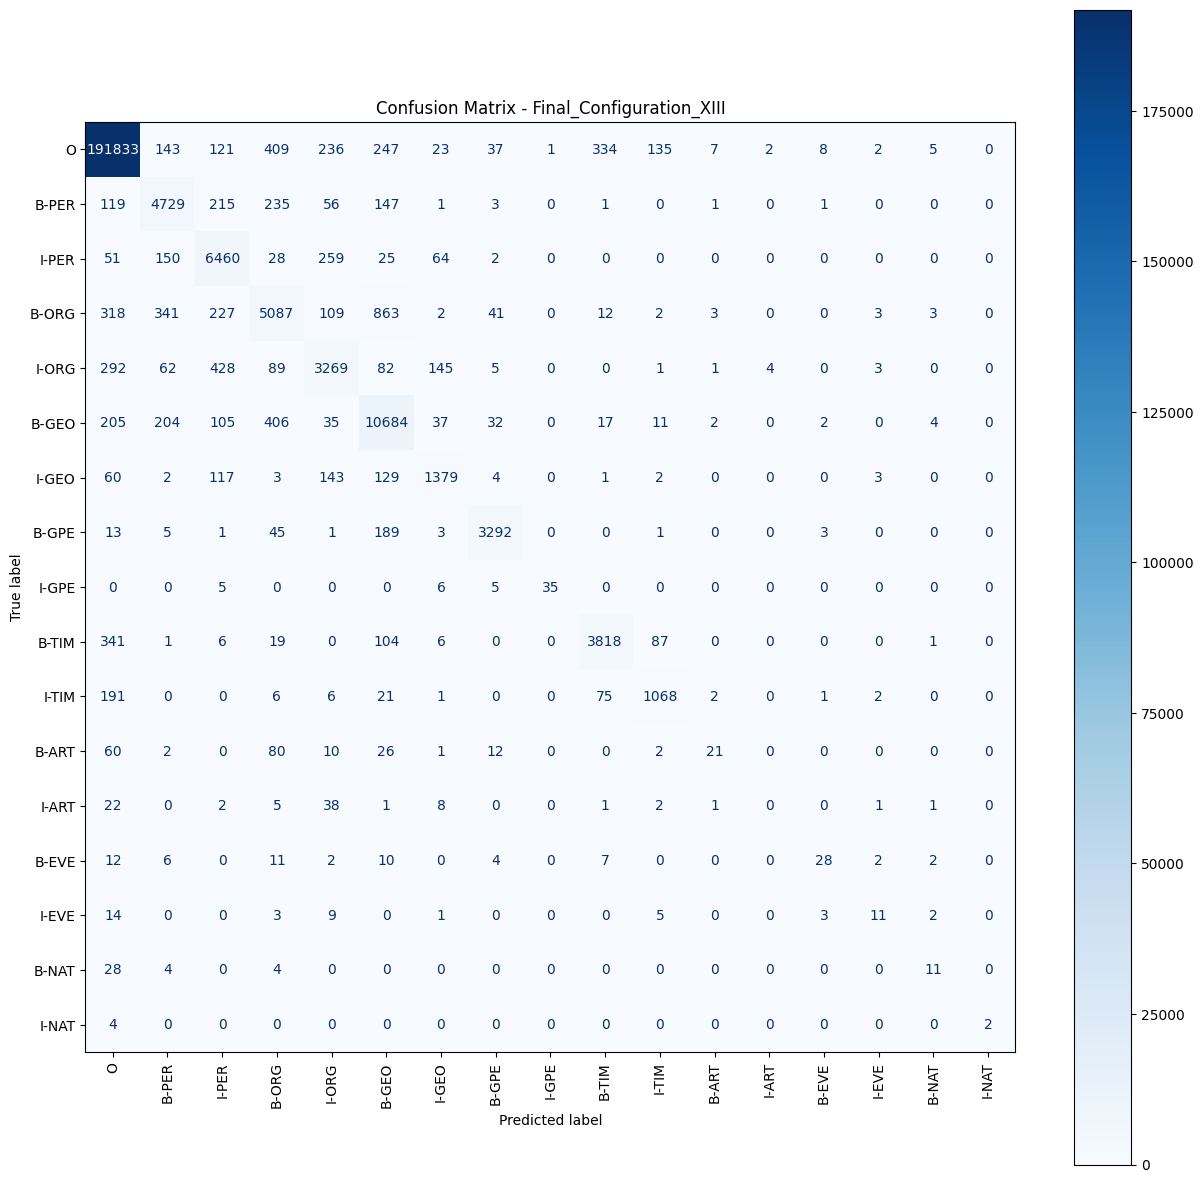


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.985721  191833  1730  1710   45637
1   B-PER          0       0         0  0.992948    4729   920   779  234482
2   I-PER          0       0         0  0.992503    6460  1227   579  232644
3   B-ORG          0       0         0  0.986439    5087  1343  1924  232556
4   I-ORG          0       0         0  0.991632    3269   904  1112  235625
5   B-GEO          0       0         0  0.987946   10684  1844  1060  227322
6   I-GEO          0       0         0  0.996837    1379   298   464  238769
7   B-GPE          0       0         0  0.998315    3292   145   261  237212
8   I-GPE          0       0         0  0.999929      35     1    16  240858
9   B-TIM          0       0         0  0.995795    3818   448   565  236079
10  I-TIM          0       0         0  0.997705    1068   248   305  239289
11  B-ART          0       0         0  0.999128      21    17   193  240679
12  I-ART          0       0         0  0.999635       0     6    82  240822
13  B-EVE          0       0         0  0.999693      28    18    56  240808
14  I-EVE          0       0         0  0.999780      11    16    37  240846
15  B-NAT          0       0         0  0.999776      11    18    36  240845
16  I-NAT          0       0         0  0.999983       2     0     4  240904


Overall Metrics:


Metric         Value
0  Precision  8.227502e-01
1     Recall  8.321042e-01
2   F1-score  8.274008e-01
3   Accuracy  9.618820e-01
4         TP  2.317270e+05
5         FP  9.183000e+03
6         FN  9.183000e+03
7         TN  3.845377e+06

In [ ]:
# Configuration XIII
# learning rate = 2e-5, batch size = 16, epoch = 2

trainer = trainer_class.train_model(2e-5, 16, 2, "Final_Configuration_XIII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XIII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XIII")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_XIV...


<ipython-input-34-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XIV-model
Generating Confusion Matrix for Final_Configuration_XIV...


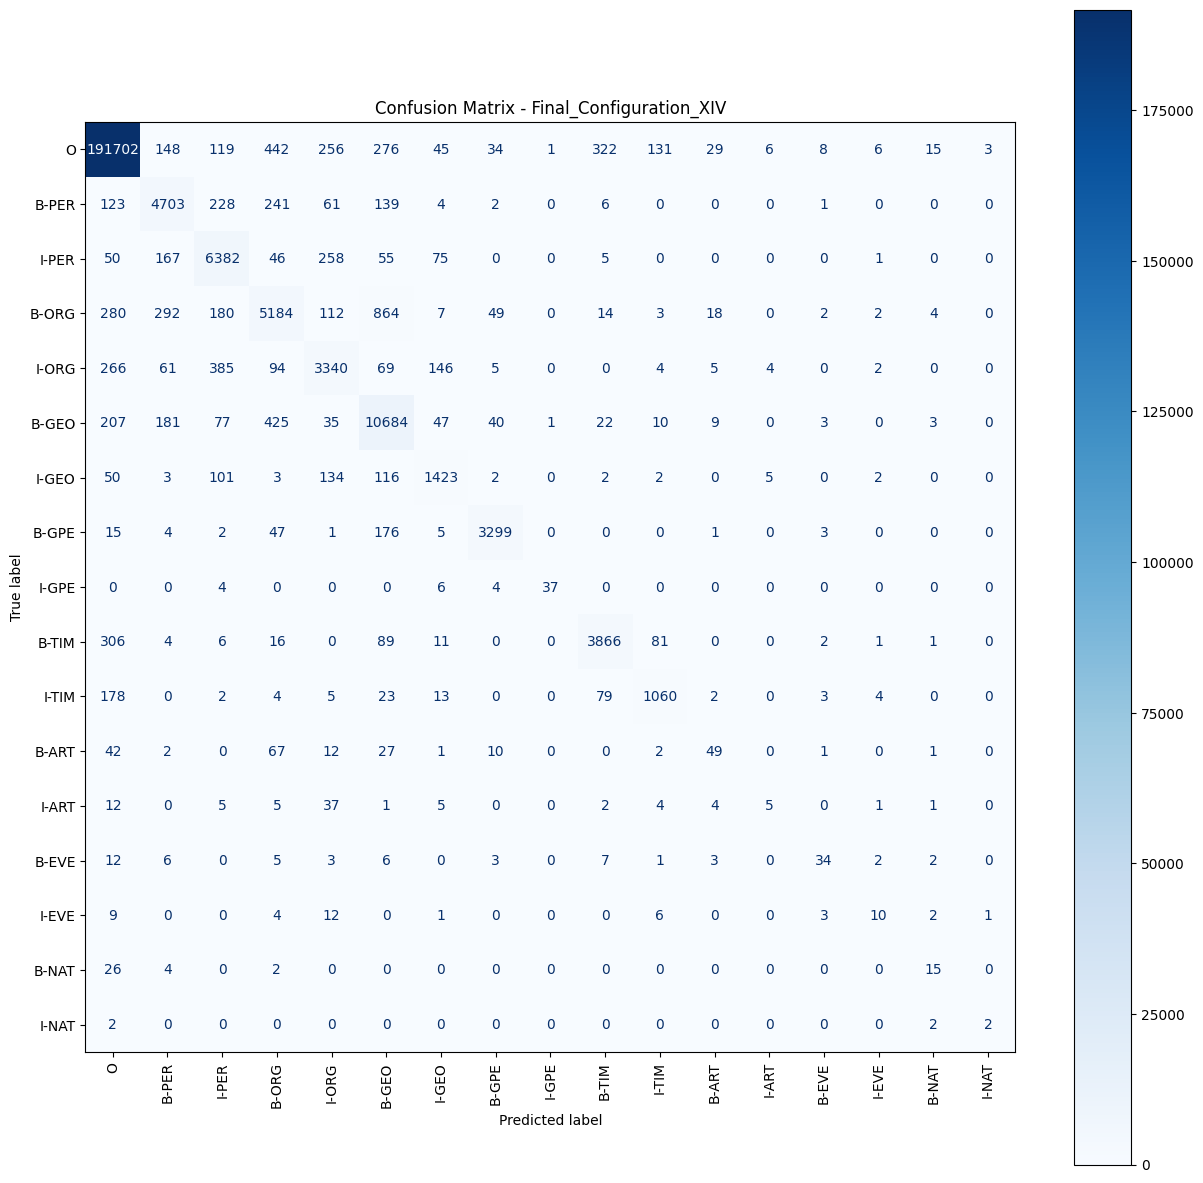


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.985808  191702  1578  1841   45789
1   B-PER          0       0         0  0.993039    4703   872   805  234530
2   I-PER          0       0         0  0.992669    6382  1109   657  232762
3   B-ORG          0       0         0  0.986601    5184  1401  1827  232498
4   I-ORG          0       0         0  0.991835    3340   926  1041  235603
5   B-GEO          0       0         0  0.987958   10684  1841  1060  227325
6   I-GEO          0       0         0  0.996737    1423   366   420  238701
7   B-GPE          0       0         0  0.998327    3299   149   254  237208
8   I-GPE          0       0         0  0.999934      37     2    14  240857
9   B-TIM          0       0         0  0.995949    3866   459   517  236068
10  I-TIM          0       0         0  0.997688    1060   244   313  239293
11  B-ART          0       0         0  0.999020      49    71   165  240625
12  I-ART          0       0         0  0.999618       5    15    77  240813
13  B-EVE          0       0         0  0.999685      34    26    50  240800
14  I-EVE          0       0         0  0.999755      10    21    38  240841
15  B-NAT          0       0         0  0.999738      15    31    32  240832
16  I-NAT          0       0         0  0.999967       2     4     4  240900


Overall Metrics:


Metric         Value
0  Precision  8.215008e-01
1     Recall  8.366212e-01
2   F1-score  8.289920e-01
3   Accuracy  9.621643e-01
4         TP  2.317950e+05
5         FP  9.115000e+03
6         FN  9.115000e+03
7         TN  3.845445e+06

In [ ]:
# Configuration XIV
# learning rate = 2e-5, batch size = 16, epoch = 3

trainer = trainer_class.train_model(2e-5, 16, 3, "Final_Configuration_XIV")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XIV")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XIV")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_XV...


<ipython-input-5-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Error creating repository: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6808f0c1-5640db9b45f48bb2398ca65b;a2642676-742f-45ae-83b8-90e4e8aeaf95)

You already created this model repo


model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XV-model
Generating Confusion Matrix for Final_Configuration_XV...


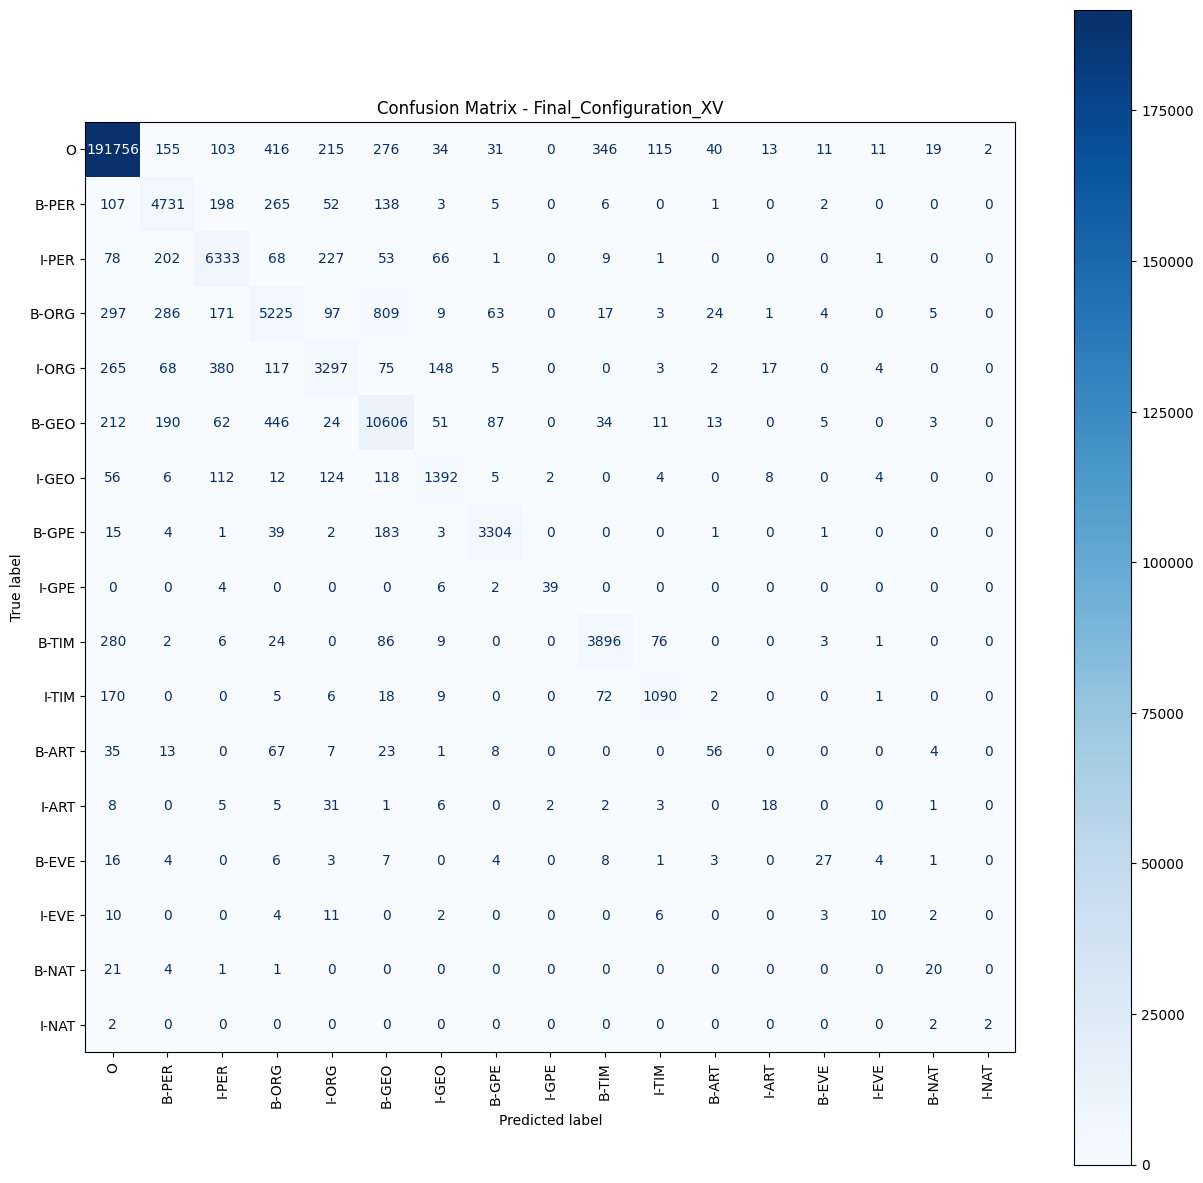


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986057  191756  1572  1787   45795
1   B-PER          0       0         0  0.992898    4731   934   777  234468
2   I-PER          0       0         0  0.992740    6333  1043   706  232828
3   B-ORG          0       0         0  0.986464    5225  1475  1786  232424
4   I-ORG          0       0         0  0.992184    3297   799  1084  235730
5   B-GEO          0       0         0  0.987859   10606  1787  1138  227379
6   I-GEO          0       0         0  0.996688    1392   347   451  238720
7   B-GPE          0       0         0  0.998091    3304   211   249  237146
8   I-GPE          0       0         0  0.999934      39     4    12  240855
9   B-TIM          0       0         0  0.995928    3896   494   487  236033
10  I-TIM          0       0         0  0.997900    1090   223   283  239314
11  B-ART          0       0         0  0.998987      56    86   158  240610
12  I-ART          0       0         0  0.999572      18    39    64  240789
13  B-EVE          0       0         0  0.999643      27    29    57  240797
14  I-EVE          0       0         0  0.999734      10    26    38  240836
15  B-NAT          0       0         0  0.999734      20    37    27  240826
16  I-NAT          0       0         0  0.999975       2     2     4  240902


Overall Metrics:


Metric         Value
0  Precision  8.209732e-01
1     Recall  8.388336e-01
2   F1-score  8.298073e-01
3   Accuracy  9.621934e-01
4         TP  2.318020e+05
5         FP  9.108000e+03
6         FN  9.108000e+03
7         TN  3.845452e+06

In [ ]:
# Configuration XV
# learning rate = 2e-5, batch size = 16, epoch = 4

trainer = trainer_class.train_model(2e-5, 16, 4, "Final_Configuration_XV")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XV")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XV")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VXI...


<ipython-input-5-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XVI-model
Generating Confusion Matrix for Final_Configuration_XVI...


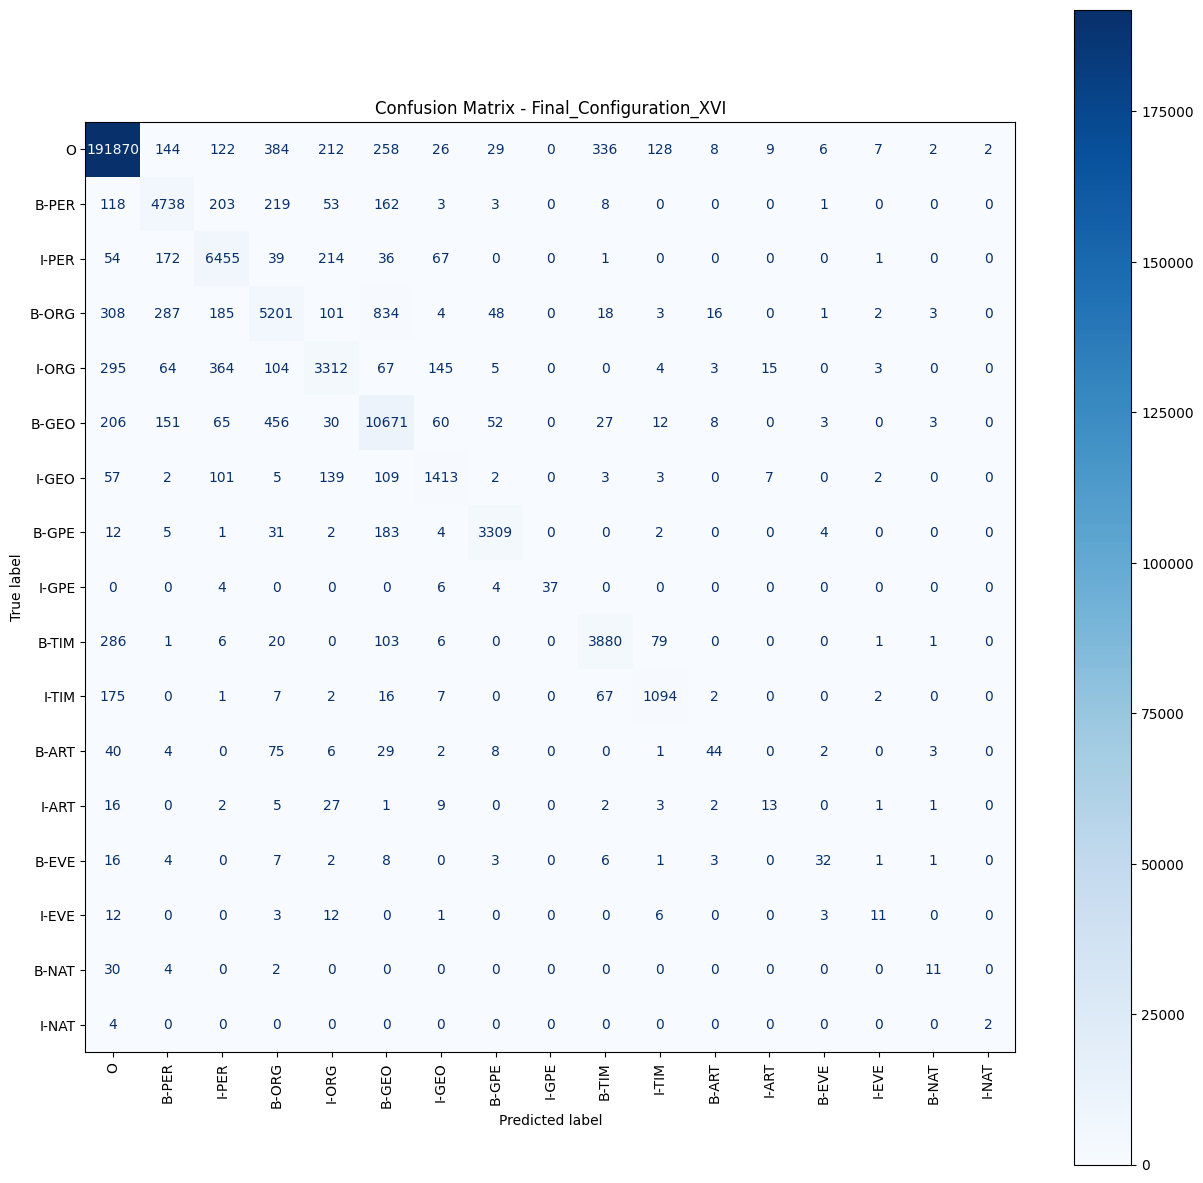


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986294  191870  1629  1673   45738
1   B-PER          0       0         0  0.993325    4738   838   770  234564
2   I-PER          0       0         0  0.993201    6455  1054   584  232817
3   B-ORG          0       0         0  0.986854    5201  1357  1810  232542
4   I-ORG          0       0         0  0.992242    3312   800  1069  235729
5   B-GEO          0       0         0  0.988049   10671  1806  1073  227360
6   I-GEO          0       0         0  0.996804    1413   340   430  238727
7   B-GPE          0       0         0  0.998348    3309   154   244  237203
8   I-GPE          0       0         0  0.999942      37     0    14  240859
9   B-TIM          0       0         0  0.995969    3880   468   503  236059
10  I-TIM          0       0         0  0.997837    1094   242   279  239295
11  B-ART          0       0         0  0.999120      44    42   170  240654
12  I-ART          0       0         0  0.999585      13    31    69  240797
13  B-EVE          0       0         0  0.999701      32    20    52  240806
14  I-EVE          0       0         0  0.999763      11    20    37  240842
15  B-NAT          0       0         0  0.999792      11    14    36  240849
16  I-NAT          0       0         0  0.999975       2     2     4  240902


Overall Metrics:


Metric         Value
0  Precision  8.278810e-01
1     Recall  8.390487e-01
2   F1-score  8.334274e-01
3   Accuracy  9.634013e-01
4         TP  2.320930e+05
5         FP  8.817000e+03
6         FN  8.817000e+03
7         TN  3.845743e+06

In [ ]:
# Configuration XVI
# learning rate = 2e-5, batch size = 32, epoch = 2

trainer = trainer_class.train_model(2e-5, 32, 2, "Final_Configuration_VXI")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XVI")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XVI")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VXII...


<ipython-input-5-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XVII-model
Generating Confusion Matrix for Final_Configuration_XVII...


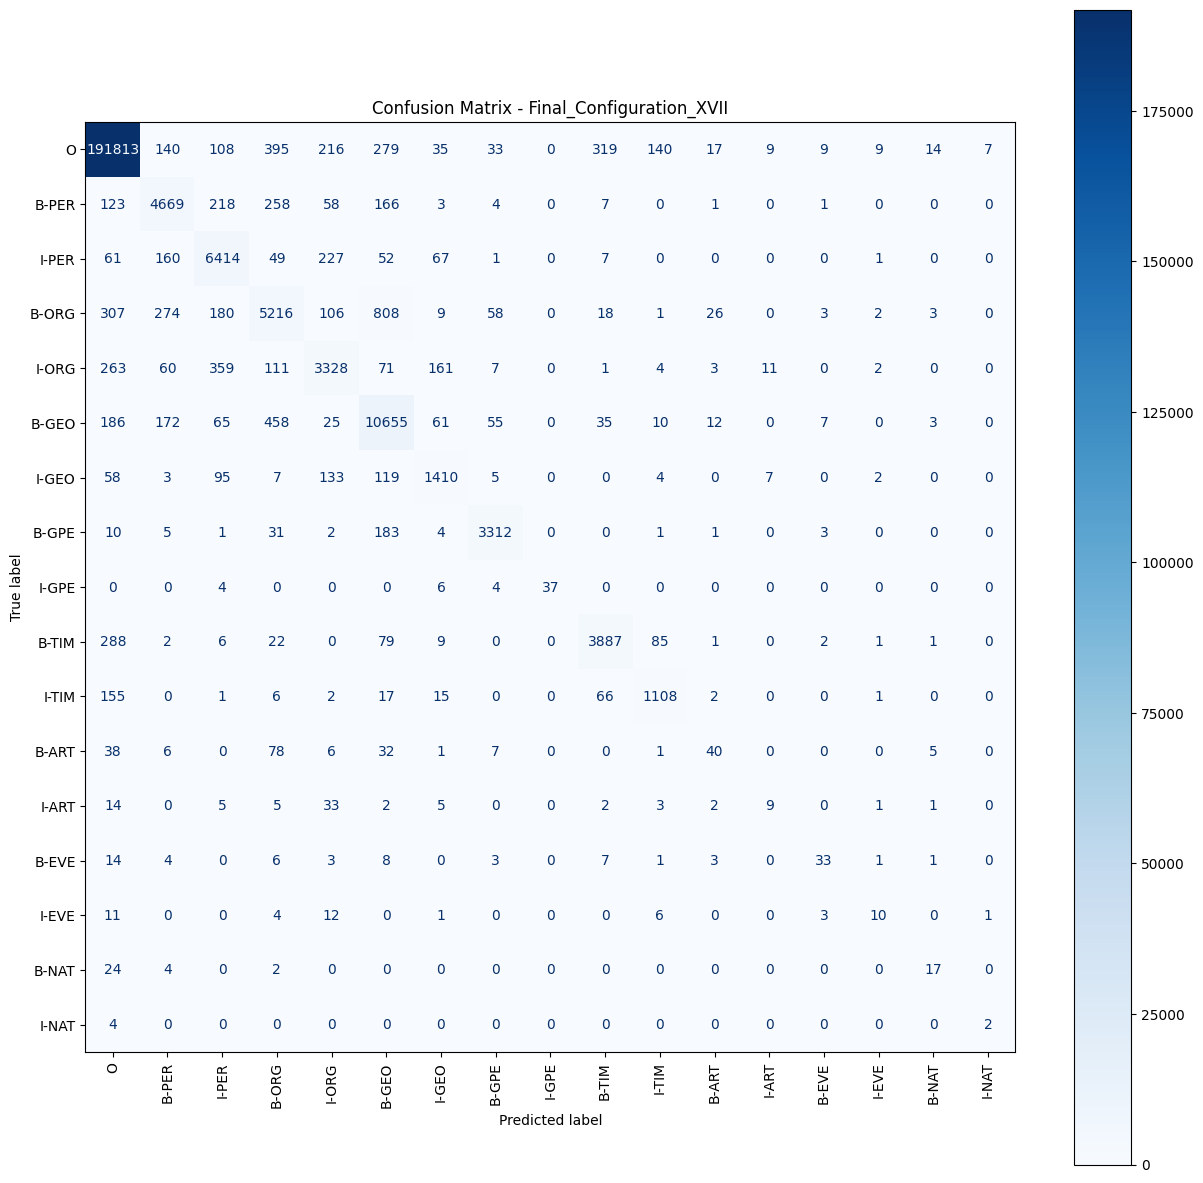


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986360  191813  1556  1730   45811
1   B-PER          0       0         0  0.993072    4669   830   839  234572
2   I-PER          0       0         0  0.993080    6414  1042   625  232829
3   B-ORG          0       0         0  0.986605    5216  1432  1795  232467
4   I-ORG          0       0         0  0.992213    3328   823  1053  235706
5   B-GEO          0       0         0  0.987942   10655  1816  1089  227350
6   I-GEO          0       0         0  0.996638    1410   377   433  238690
7   B-GPE          0       0         0  0.998265    3312   177   241  237180
8   I-GPE          0       0         0  0.999942      37     0    14  240859
9   B-TIM          0       0         0  0.996023    3887   462   496  236065
10  I-TIM          0       0         0  0.997837    1108   256   265  239281
11  B-ART          0       0         0  0.998995      40    68   174  240628
12  I-ART          0       0         0  0.999585       9    27    73  240801
13  B-EVE          0       0         0  0.999672      33    28    51  240798
14  I-EVE          0       0         0  0.999759      10    20    38  240842
15  B-NAT          0       0         0  0.999759      17    28    30  240835
16  I-NAT          0       0         0  0.999950       2     8     4  240896


Overall Metrics:


Metric         Value
0  Precision  8.234406e-01
1     Recall  8.380654e-01
2   F1-score  8.306886e-01
3   Accuracy  9.628492e-01
4         TP  2.319600e+05
5         FP  8.950000e+03
6         FN  8.950000e+03
7         TN  3.845610e+06

In [ ]:
# Configuration XVII
# learning rate = 2e-5, batch size = 32, epoch = 3

trainer = trainer_class.train_model(2e-5, 32, 3, "Final_Configuration_VXII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XVII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XVII")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Final_Configuration_VXIII...


<ipython-input-5-a3e0c81f3e61>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Model uploaded to Hugging Face at: farizkuy/skripsi-bert-ner-Final_Configuration_XVIII-model
Generating Confusion Matrix for Final_Configuration_XVIII...


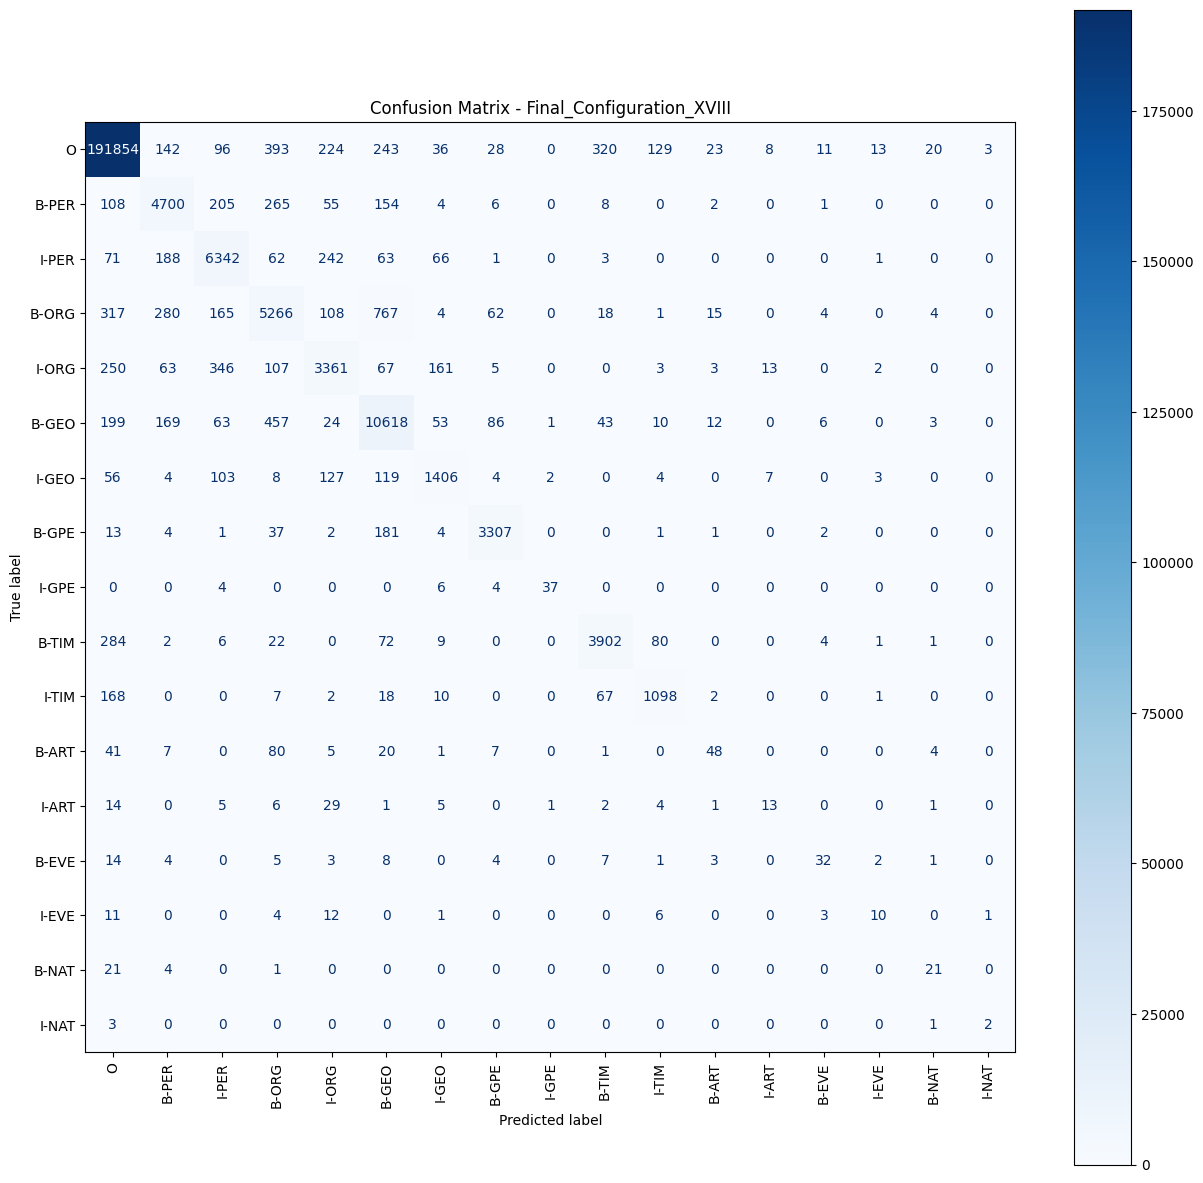


Per-Label Metrics:


Label  Precision  Recall  F1-score  Accuracy      TP    FP    FN      TN
0       O          0       0         0  0.986472  191854  1570  1689   45797
1   B-PER          0       0         0  0.993047    4700   867   808  234535
2   I-PER          0       0         0  0.992981    6342   994   697  232877
3   B-ORG          0       0         0  0.986721    5266  1454  1745  232445
4   I-ORG          0       0         0  0.992308    3361   833  1020  235696
5   B-GEO          0       0         0  0.988216   10618  1713  1126  227453
6   I-GEO          0       0         0  0.996692    1406   360   437  238707
7   B-GPE          0       0         0  0.998120    3307   207   246  237150
8   I-GPE          0       0         0  0.999925      37     4    14  240855
9   B-TIM          0       0         0  0.996057    3902   469   481  236058
10  I-TIM          0       0         0  0.997866    1098   239   275  239298
11  B-ART          0       0         0  0.999054      48    62   166  240634
12  I-ART          0       0         0  0.999597      13    28    69  240800
13  B-EVE          0       0         0  0.999655      32    31    52  240795
14  I-EVE          0       0         0  0.999747      10    23    38  240839
15  B-NAT          0       0         0  0.999747      21    35    26  240828
16  I-NAT          0       0         0  0.999967       2     4     4  240900


Overall Metrics:


Metric         Value
0  Precision  8.238184e-01
1     Recall  8.398169e-01
2   F1-score  8.317407e-01
3   Accuracy  9.630858e-01
4         TP  2.320170e+05
5         FP  8.893000e+03
6         FN  8.893000e+03
7         TN  3.845667e+06

In [ ]:
# Configuration XVIII
# learning rate = 2e-5, batch size = 32, epoch = 4

trainer = trainer_class.train_model(2e-5, 32, 4, "Final_Configuration_VXIII")
uploader.upload_model_to_huggingface(trainer, ner_model.get_tokenizer(), "Final_Configuration_XVIII")
metrics.generate_confusion_matrix(trainer, datasets, "Final_Configuration_XVIII")